# Анализ данных House Prices - Advanced Regression Techniques

In [1]:
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline

In [2]:
path_train = '../train.csv'

In [3]:
path_test = '../test.csv'

In [4]:
df_train = pd.read_csv(path_train, sep=',')
df_test = pd.read_csv(path_test, sep=',')
train_clean = pd.read_csv(path_train, sep=',')
test_clean = pd.read_csv(path_test, sep=',')

# Визуализация

*Корреляция целевой переменной с признаками*

In [5]:
correlation_matrix = df_train.corr().round(2).drop(columns='Id')

In [6]:
best_correlation = correlation_matrix[abs(correlation_matrix['SalePrice']) > 0.5]

In [7]:
col = correlation_matrix[abs(correlation_matrix['SalePrice']) > 0.5].index

In [8]:
best_corr_sort = best_correlation[col]

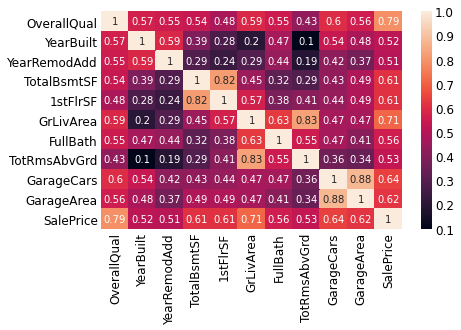

In [9]:
sns.heatmap(data=best_corr_sort, annot=True);

*Видна сильная корреляция SalePrice с признаками OverallQual, GrLivArea, TotatBsmtSF - цены за дом и оценки материалов и отделки, жилой площади, площадь подвала*

*Также наблюдается корреляция с переменными, описывающими наличие гаража в доме: GarageCars и GarageArea*

**Целевая переменная и ID**

In [10]:
Id_train=df_train['Id']
Id_test=df_test['Id']
Y=df_train['SalePrice']
#прологарифмируем у
y = np.log2(Y)

**Распределение целевой переменной**

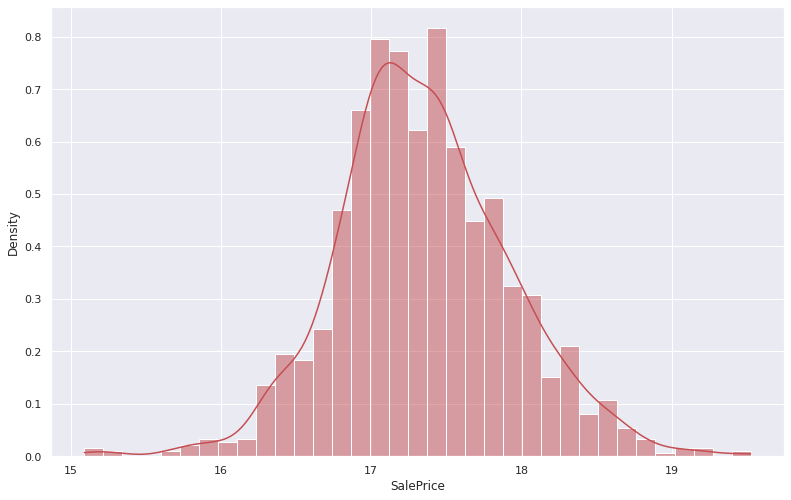

In [11]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(y, color='r', kde=True, stat='density');
plt.show();

**Связь между целевой переменной и независимыми переменными**

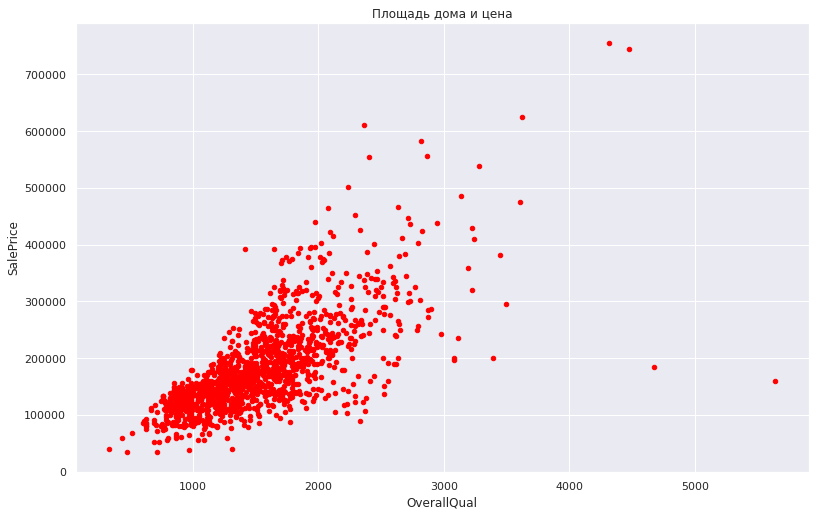

In [12]:
plt.scatter(df_train['GrLivArea'], df_train['SalePrice'], s=20, c = 'red');
plt.title('Площадь дома и цена');
plt.xlabel('OverallQual');
plt.ylabel('SalePrice');

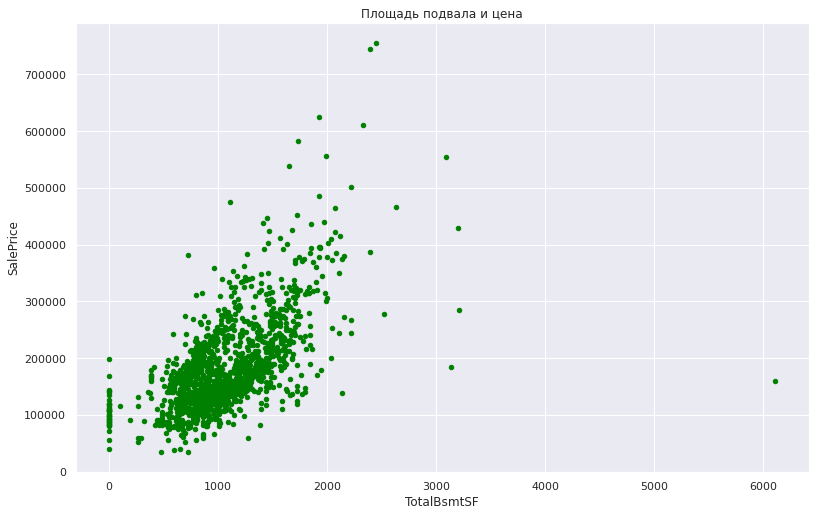

In [13]:
plt.scatter(df_train['TotalBsmtSF'], df_train['SalePrice'], s=20, color = 'green');
plt.title('Площадь подвала и цена');
plt.xlabel('TotalBsmtSF');
plt.ylabel('SalePrice');

# Определение типа данных 

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

# Нахождение пустых значений в каждой колонке (в процентах)

In [16]:
null_train = pd.DataFrame((df_train.isnull().sum()/df_train.shape[0] * 100), columns=['sum of null']).sort_values(by='sum of null', ascending=False)

In [17]:
null_train = null_train[null_train['sum of null'] > 0]

In [18]:
null_train['description'] = ['Качество бассейна','Прочие признаки, не включенные в другие категории','Тип подъезда к аллее','Качество забора','Качество камина','Площадь улицы, соединенной с недвижимостью','Год строительства гаража','Состояние гаража','Расположение гаража','Внутренняя отделка гаража','Качество гаража','Рейтинг площади подвала (если несколько типов)','Стены подвала в коридоре или на уровне сада','Оценка высоты подвала','Общая оценка подвала','Рейтинг готовой площади подвала','Площадь облицовки каменной кладкой в квадратных футах','Тип облицовки кладки', 'Электрическая система']

In [19]:
null_train

,sum of null,description
PoolQC,99.520548,Качество бассейна
MiscFeature,96.301370,"Прочие признаки, не включенные в другие категории"
Alley,93.767123,Тип подъезда к аллее
Fence,80.753425,Качество забора
FireplaceQu,47.260274,Качество камина
LotFrontage,17.739726,"Площадь улицы, соединенной с недвижимостью"
GarageYrBlt,5.547945,Год строительства гаража
GarageCond,5.547945,Состояние гаража
GarageType,5.547945,Расположение гаража
GarageFinish,5.547945,Внутренняя отделка гаража


In [20]:
null_test = pd.DataFrame((df_train.isnull().sum()/df_train.shape[0] * 100), columns=['sum of null']).sort_values(by='sum of null', ascending=False)

In [21]:
null_test=null_test[null_test['sum of null'] > 0]

In [22]:
null_test['description'] = ['Качество бассейна','Прочие признаки, не включенные в другие категории','Тип подъезда к аллее','Качество забора','Качество камина','Площадь улицы, соединенной с недвижимостью','Год строительства гаража','Состояние гаража','Расположение гаража','Внутренняя отделка гаража','Качество гаража','Рейтинг площади подвала (если несколько типов)','Стены подвала в коридоре или на уровне сада','Оценка высоты подвала','Общая оценка подвала','Рейтинг готовой площади подвала','Площадь облицовки каменной кладкой в квадратных футах','Тип облицовки кладки', 'Электрическая система']

In [23]:
null_test

,sum of null,description
PoolQC,99.520548,Качество бассейна
MiscFeature,96.301370,"Прочие признаки, не включенные в другие категории"
Alley,93.767123,Тип подъезда к аллее
Fence,80.753425,Качество забора
FireplaceQu,47.260274,Качество камина
LotFrontage,17.739726,"Площадь улицы, соединенной с недвижимостью"
GarageYrBlt,5.547945,Год строительства гаража
GarageCond,5.547945,Состояние гаража
GarageType,5.547945,Расположение гаража
GarageFinish,5.547945,Внутренняя отделка гаража


# Убираем очевидно ненужные колонки

In [24]:
df_train.drop(columns=['Id','PoolQC', 'Utilities'], axis=1, inplace=True)
df_test.drop(columns=['Id','PoolQC', 'Utilities'], axis=1, inplace=True)

# Дисперсионный анализ ANOVA для удаления ненужных категориальных признаков

*Применим дисперсионный анализ к категориальным признакам*

In [25]:
cat=[col for col in df_train.columns if df_train[col].dtype=='object']

In [26]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

d = dict()

for x in cat:
    model = ols('SalePrice' + '~' + x, data = df_train).fit() #Oridnary least square method
    result_anova = sm.stats.anova_lm(model, typ=1) # ANOVA Test
    d[result_anova.index[0]] = result_anova.iloc[0, -1]
res_anova = pd.DataFrame(d.values(), columns = ['PR[>F]'], index = d.keys())

*Какие признаки не влияют на SalePrice*

In [52]:
res_anova

,PR[>F]
MSZoning,8.817634e-35
Street,1.170486e-01
Alley,4.899826e-08
LotShape,6.447524e-25
LandContour,2.742217e-08
LotConfig,3.163167e-06
LandSlope,1.413964e-01
Neighborhood,1.558600e-225
Condition1,8.904549e-08
Condition2,4.342566e-02


In [27]:
res_anova[res_anova['PR[>F]']>=0.05]

,PR[>F]
Street,0.117049
LandSlope,0.141396
MiscFeature,0.104728


*Удалим целевую переменую и получившиеся колонки из train и test*

In [28]:
df_train.drop(columns=['SalePrice', 'Street', 'LandSlope', 'MiscFeature'], axis=1, inplace=True)
df_test.drop(columns=['Street', 'LandSlope', 'MiscFeature'], axis=1, inplace=True)

# Нахождение категориальных и числовых признаков

In [29]:
cat=[col for col in df_train.columns if df_train[col].dtype=='object']
num=[col for col in df_train.columns if df_train[col].dtype!='object']
# cat
print('Числовые признаки: \n')
print(*num)

Числовые признаки: 

MSSubClass LotFrontage LotArea OverallQual OverallCond YearBuilt YearRemodAdd MasVnrArea BsmtFinSF1 BsmtFinSF2 BsmtUnfSF TotalBsmtSF 1stFlrSF 2ndFlrSF LowQualFinSF GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr TotRmsAbvGrd Fireplaces GarageYrBlt GarageCars GarageArea WoodDeckSF OpenPorchSF EnclosedPorch 3SsnPorch ScreenPorch PoolArea MiscVal MoSold YrSold


In [30]:
print('Категориальные признаки: \n')
print(*cat)

Категориальные признаки: 

MSZoning Alley LotShape LandContour LotConfig Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual Functional FireplaceQu GarageType GarageFinish GarageQual GarageCond PavedDrive Fence SaleType SaleCondition


# Объединение df_test и df_train и заполнение пропусков

*Заполним пропуски средними значениями для числовых данных*

In [31]:
for i in num:
    df_train[i].fillna(df_train[i].mean(), inplace=True)
    df_test[i].fillna(df_test[i].mean(), inplace=True)

*Заполним пропуски наиболее часто встречающимися для категориальных данных*

In [32]:
for i in cat:
    df_train[i].fillna(df_train[i].mode()[0], inplace=True)
    df_test[i].fillna(df_test[i].mode()[0], inplace=True)

In [33]:
df_train.shape

(1460, 74)

In [34]:
df_test.shape

(1459, 74)

*Объединение данных*

In [35]:
house = df_train.append(df_test)

In [36]:
house.shape

(2919, 74)

In [37]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Grvl,Reg,Lvl,Inside,CollgCr,Norm,...,0,0,0,0,MnPrv,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Grvl,Reg,Lvl,FR2,Veenker,Feedr,...,0,0,0,0,MnPrv,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Grvl,IR1,Lvl,Inside,CollgCr,Norm,...,0,0,0,0,MnPrv,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Grvl,IR1,Lvl,Corner,Crawfor,Norm,...,272,0,0,0,MnPrv,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Grvl,IR1,Lvl,FR2,NoRidge,Norm,...,0,0,0,0,MnPrv,0,12,2008,WD,Normal


# Нахождение дискретных, непрерывных и временных переменных

In [38]:
con=[col for col in num if house[col].nunique()>25] #непрерывные признаки
dis=[col for col in num if house[col].nunique()<25] #дискретные признаки
yea=[col for col in house.columns if 'Yr' in col or 'Year' in  col or 'yr' in  col or 'YR' in  col] #временные признаки

*Заполним корректно NA в числовых и категориальных признаках значением NAN*

In [39]:
for i in house.columns:
    house[i] = house[i].apply(lambda x: 'NAN' if x=='NA' else x)

*Скорректируем временные переменные*

In [40]:
house[yea]=2021 - house[yea]

# OneHotEncoding категориальные переменные

In [41]:
house_dummies = pd.get_dummies(house, columns=cat, dummy_na=True, drop_first=True)

*house_dummies - датафрейм c новыми колонками*

In [42]:
house_dummies.shape

(2919, 274)

In [43]:
# сохраним копию house без преобразования данных
df = house.copy()

In [44]:
df.shape

(2919, 74)

In [45]:
house = house_dummies.copy()

In [46]:
house = house.loc[:,~house.columns.duplicated()]

In [47]:
house.shape

(2919, 274)

# Стандартизируем дискретные переменные

In [48]:
scaler= StandardScaler()
house[dis]= scaler.fit_transform(house[dis])

# Разделим house на train и test и добавим SalePrice к train

In [49]:
train = house.iloc[0:df_train.shape[0]]
test = house.iloc[train.shape[0]:]
train.shape, test.shape, df_train.shape, df_test.shape

((1460, 274), (1459, 274), (1460, 74), (1459, 74))

*Прибавим к обучающей выборке целевую логарифмированную переменную*

In [50]:
train = pd.concat([train, y], axis=1)
train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan,SalePrice
0,0.067331,65.0,8450,0.646183,-0.507284,18,18,196.0,706.0,0.0,...,0,1,0,0,0,0,1,0,0,17.669688
1,-0.873616,80.0,9600,-0.063185,2.188279,45,45,0.0,978.0,0.0,...,0,1,0,0,0,0,1,0,0,17.469610
2,0.067331,68.0,11250,0.646183,-0.507284,20,19,162.0,486.0,0.0,...,0,1,0,0,0,0,1,0,0,17.769915
3,0.302568,60.0,9550,0.646183,-0.507284,106,51,0.0,216.0,0.0,...,0,1,0,0,0,0,0,0,0,17.095067
4,0.067331,84.0,14260,1.355551,-0.507284,21,21,350.0,655.0,0.0,...,0,1,0,0,0,0,1,0,0,17.931569


# X and y в обучающей выборке

In [51]:
#Без логарифмирования
Y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [52]:
#С логарифмированием
y

0       17.669688
1       17.469610
2       17.769915
3       17.095067
4       17.931569
          ...    
1455    17.416995
1456    17.680030
1457    18.023776
1458    17.116801
1459    17.170355
Name: SalePrice, Length: 1460, dtype: float64

In [53]:
# Независимые переменные
X=train.drop(['SalePrice'],axis=1)

In [54]:
X

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067331,65.0,8450,0.646183,-0.507284,18,18,196.0,706.0,0.0,...,0,0,1,0,0,0,0,1,0,0
1,-0.873616,80.0,9600,-0.063185,2.188279,45,45,0.0,978.0,0.0,...,0,0,1,0,0,0,0,1,0,0
2,0.067331,68.0,11250,0.646183,-0.507284,20,19,162.0,486.0,0.0,...,0,0,1,0,0,0,0,1,0,0
3,0.302568,60.0,9550,0.646183,-0.507284,106,51,0.0,216.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,0.067331,84.0,14260,1.355551,-0.507284,21,21,350.0,655.0,0.0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.067331,62.0,7917,-0.063185,-0.507284,22,21,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
1456,-0.873616,85.0,13175,-0.063185,0.391237,43,33,119.0,790.0,163.0,...,0,0,1,0,0,0,0,1,0,0
1457,0.302568,66.0,9042,0.646183,3.086800,80,15,0.0,275.0,0.0,...,0,0,1,0,0,0,0,1,0,0
1458,-0.873616,68.0,9717,-0.772552,0.391237,71,25,0.0,49.0,1029.0,...,0,0,1,0,0,0,0,1,0,0


# Train Test Split

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Модель Градиентный бустинг

In [56]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

clf = LGBMRegressor()

param_grid = {
    'boosting_type': ['gbdt', 'rf'],
    'num_leaves': np.arange(10, 30, 4),
    'max_depth': [2, 3, 5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': np.arange(80, 120, 20)
}

# создаем объект
cv1 = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', 
    cv=5, # количество фолдов
    verbose=4, # сколько печатать сообщений
    n_jobs=-1, # насколько параллелельно считаем
)

In [57]:
cv1.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.39208075 -0.39208075 -0.39208075 -0.39208075 -0.39208075 -0.36505417
 -0.36505417 -0.36505417 -0.36505417 -0.36505417 -0.36682779 -0.36682779
 -0.36682779 -0.36682779 -0.36682779 -0.3370294  -0.3370294  -0.3370294
 -0.3370294  -0.3370294  -0.35988628 -0.35159652 -0.34655112 -0.34372455
 -0.34322545 -0.32999743 -0.32137122 -0.31642842 -0.31375878 -0.31326579
 -0.35988628 -0.35156744 -0.34639602 -0.34275094 -0.34044933 -0.32999743
 -0.32158544 -0.3160614  -0.31217061 -0.30944094 -0.35988628 -0.35156744
 -0.34639602 -0.34275094 -0.34044933 -0.32999743 -0.32158544 -0.3160614
 -0.31217061 -0.30944094 -0.22465724 -0.22465724 -0.22465724 -0.22465724
 -0.22465724 -0.21503174 -0.21503174 -0.21503174 -0.21503174 -0.21503174
 -0.21078353 -0.21078353 -0.21078353 -0.21078353 -0.21078353 -0.20473662
 -0.20473662 -0.20473662 -0.20473662 -0.20473662 

GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'rf'],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 5, 10, 20],
                         'n_estimators': array([ 80, 100]),
                         'num_leaves': array([10, 14, 18, 22, 26])},
             scoring='neg_root_mean_squared_error', verbose=4)

In [58]:
cv1.best_estimator_

LGBMRegressor(max_depth=10, num_leaves=10)

In [59]:
cv1.best_params_, cv1.best_score_ 

({'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 10,
  'n_estimators': 100,
  'num_leaves': 10},
 -0.19301767174614434)

In [60]:
#предсказанные значения y для обучающей выборки
best_model1 = cv1.best_estimator_
y_pred_1 = best_model1.predict(X_test)

In [61]:
#y_test.to_numpy()

In [62]:
cv1_results = pd.DataFrame(cv1.cv_results_)

In [63]:
cv1_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.059332,0.005253,0.007024,0.001905,gbdt,0.01,2,80,10,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",-0.401795,-0.397101,-0.435278,-0.395396,-0.330833,-0.392081,0.033905,146
1,0.053807,0.003105,0.007008,0.001791,gbdt,0.01,2,80,14,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",-0.401795,-0.397101,-0.435278,-0.395396,-0.330833,-0.392081,0.033905,146
2,0.055858,0.005865,0.007283,0.001653,gbdt,0.01,2,80,18,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",-0.401795,-0.397101,-0.435278,-0.395396,-0.330833,-0.392081,0.033905,146
3,0.063800,0.009768,0.005590,0.000445,gbdt,0.01,2,80,22,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",-0.401795,-0.397101,-0.435278,-0.395396,-0.330833,-0.392081,0.033905,146
4,0.049470,0.001537,0.005567,0.000234,gbdt,0.01,2,80,26,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",-0.401795,-0.397101,-0.435278,-0.395396,-0.330833,-0.392081,0.033905,146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.026653,0.001201,0.000000,0.000000,rf,0.1,20,100,10,"{'boosting_type': 'rf', 'learning_rate': 0.1, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,201
296,0.025363,0.001109,0.000000,0.000000,rf,0.1,20,100,14,"{'boosting_type': 'rf', 'learning_rate': 0.1, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,202
297,0.024943,0.001813,0.000000,0.000000,rf,0.1,20,100,18,"{'boosting_type': 'rf', 'learning_rate': 0.1, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
298,0.029688,0.003431,0.000000,0.000000,rf,0.1,20,100,22,"{'boosting_type': 'rf', 'learning_rate': 0.1, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,246


In [64]:
from sklearn.metrics import mean_squared_error
#Среднеквадратичная ошибка модели
mse1 = mean_squared_error(y_test, y_pred_1)
mse1

0.03788125966544307

In [65]:
#Среднеквадратичное отклонение
rmse1 = np.sqrt(mse1)
rmse1

0.1946310860716835

In [66]:
y_pred = best_model1.predict(test)

*Загрузим в Kaggle*

In [67]:
pred_y_test1 = pd.concat([test_clean['Id'], pd.DataFrame(2**y_pred, columns=['SalePrice'])], axis=1)
pred_y_test1.to_csv('lgbm', index=False)

In [68]:
!head lgbm

Id,SalePrice
1461,125788.61869132893
1462,155417.98905068674
1463,180788.7182874516
1464,191482.93192622092
1465,204489.83534579357
1466,177100.2639661245
1467,173340.45072048556
1468,173658.69630197444
1469,198701.6574225558


# Модель Линейная регрессия

*Ridge Linear Regression*

In [69]:
from sklearn.linear_model import Ridge

clf=Ridge()

parameters={'alpha':[15, 20, 25, 30],
            'solver' : ['auto', 'svd', 'lsqr', 'saga'],
            'random_state': [1, None],
            'normalize': [True, False],
            'fit_intercept': [True, False]
           }

cv2=GridSearchCV(clf, 
                 parameters, 
                 scoring='neg_mean_squared_error',
                 cv=5, 
                 refit=True, 
                 n_jobs=4)

In [70]:
cv2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=4,
             param_grid={'alpha': [15, 20, 25, 30],
                         'fit_intercept': [True, False],
                         'normalize': [True, False], 'random_state': [1, None],
                         'solver': ['auto', 'svd', 'lsqr', 'saga']},
             scoring='neg_mean_squared_error')

In [71]:
cv2.best_params_, cv2.best_score_ 

({'alpha': 15,
  'fit_intercept': True,
  'normalize': False,
  'random_state': 1,
  'solver': 'svd'},
 -0.04582244450333497)

In [72]:
#предсказанные значения y для обучающей выборки
best_model2 = cv2.best_estimator_
y_pred_2 = best_model2.predict(X_test)

In [73]:
cv2_results = pd.DataFrame(cv2.cv_results_)

In [74]:
#Среднеквадратичная ошибка
mse2 = mean_squared_error(y_test, y_pred_2)
mse2

0.03766433291492053

In [75]:
#Среднеквадратичное отклонение
rmse2 = np.sqrt(mse2)
rmse2

0.1940730092385866

*Lasso Linear Regression*

In [76]:
from sklearn.linear_model import Lasso

clf = Lasso()

parameters = {'alpha':[0.1, 1, 0.2],
              'random_state': [1, None],
              'positive': [True, False],
              'selection' : ['cyclic', 'random'],
              'normalize': [True, False]
             }

cv3= GridSearchCV(clf, 
                  parameters, 
                  scoring='neg_mean_squared_error',
                  cv=5, 
                  refit=True, 
                  n_jobs=-1)

In [77]:
cv3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 0.2], 'normalize': [True, False],
                         'positive': [True, False], 'random_state': [1, None],
                         'selection': ['cyclic', 'random']},
             scoring='neg_mean_squared_error')

In [78]:
cv3.best_params_, cv3.best_score_ 

({'alpha': 0.2,
  'normalize': False,
  'positive': False,
  'random_state': None,
  'selection': 'random'},
 -0.07981615693980605)

In [79]:
#предсказанные значения y для обучающей выборки
best_model3 = cv3.best_estimator_
y_pred_3 = best_model3.predict(X_test)

In [80]:
cv3_results = pd.DataFrame(cv3.cv_results_)

In [81]:
#Среднеквадратичная ошибка
mse3 = mean_squared_error(y_test, y_pred_3)
mse3

0.06892123316498829

In [82]:
#Среднеквадратичное отклонение
rmse3 = np.sqrt(mse3)
rmse3

0.26252853781063173

*Linear regression*

In [83]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression()

parameters = {'fit_intercept':[True, False],
              'normalize': [True, False],
              'copy_X': [True, False],
              'positive' : [True, False],
              'n_jobs': [-1, 1, None],
              'normalize': [True, False]
             }

cv4= GridSearchCV(clf, 
                  parameters, 
                  scoring='neg_mean_squared_error',
                  cv=5, 
                  refit=True, 
                  n_jobs=-1)

In [84]:
cv4.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': [-1, 1, None], 'normalize': [True, False],
                         'positive': [True, False]},
             scoring='neg_mean_squared_error')

In [85]:
cv4.best_params_, cv4.best_score_

({'copy_X': True,
  'fit_intercept': True,
  'n_jobs': -1,
  'normalize': False,
  'positive': False},
 -0.0874665668913358)

In [86]:
#предсказанные значения y для обучающей выборки
best_model4 = cv4.best_estimator_
y_pred_4 = best_model4.predict(X_test)

In [87]:
cv4_results = pd.DataFrame(cv4.cv_results_)

In [88]:
#Среднеквадратичная ошибка
mse4 = mean_squared_error(y_test, y_pred_4)
mse4

0.03962970973079247

In [89]:
#Среднеквадратичное отклонение
rmse4 = np.sqrt(mse4)
rmse4

0.1990721219327118

*ElasticNet*

In [90]:
from sklearn.linear_model import ElasticNet

clf = ElasticNet()

parameters = {'alpha':[0.01, 0.05, 0.1],
              'random_state': [1, None],
              'positive': [True, False],
              'selection' : ['cyclic', 'random'],
              'l1_ratio': [0, 0.2, 0.5],
              'max_iter': [500, 1000, 300],
              'warm_start': [True, False]
             }

cv5= GridSearchCV(clf, 
                  parameters, 
                  scoring='neg_mean_squared_error',
                  cv=5, 
                  refit=True, 
                  n_jobs=-1)

In [91]:
cv5.fit(X_train, y_train)

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.968991829279865, tolerance: 0.038688135536583595
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.05, 0.1], 'l1_ratio': [0, 0.2, 0.5],
                         'max_iter': [500, 1000, 300],
                         'positive': [True, False], 'random_state': [1, None],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             scoring='neg_mean_squared_error')

In [92]:
cv5.best_params_, cv5.best_score_

({'alpha': 0.01,
  'l1_ratio': 0,
  'max_iter': 1000,
  'positive': False,
  'random_state': None,
  'selection': 'random',
  'warm_start': False},
 -0.045891733603746244)

In [93]:
#предсказанные значения y для обучающей выборки
best_model5 = cv5.best_estimator_
y_pred_5 = best_model5.predict(X_test)

In [94]:
cv5_results = pd.DataFrame(cv5.cv_results_)

In [95]:
#Среднеквадратичная ошибка
mse5 = mean_squared_error(y_test, y_pred_5)
mse5

0.03766845885061687

In [96]:
#Среднеквадратичное отклонение
rmse5 = np.sqrt(mse5)
rmse5

0.19408363880197854

# Модель Метод ближайших соседей

*KNeighborsRegressor*

In [97]:
from sklearn.neighbors import KNeighborsRegressor

clf=KNeighborsRegressor()

parameters={'n_neighbors':[3, 5, 7, 10, 15],
            'weights': ['uniform', 'distance'],
            'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1, 2, 3],
            'leaf_size': [10, 30, 50, 70]
           }

cv6=GridSearchCV(clf, 
                 parameters, 
                 scoring='neg_mean_squared_error',
                 cv=5, 
                 refit=True, 
                 n_jobs=4)

In [98]:
cv6.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 30, 50, 70],
                         'n_neighbors': [3, 5, 7, 10, 15], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [99]:
cv6.best_params_, cv6.best_score_ 

({'algorithm': 'auto',
  'leaf_size': 10,
  'n_neighbors': 7,
  'p': 1,
  'weights': 'distance'},
 -0.08410103581200276)

In [100]:
#предсказанные значения y для обучающей выборки
best_model6 = cv6.best_estimator_
y_pred_6 = best_model6.predict(X_test)

In [101]:
cv6_results = pd.DataFrame(cv6.cv_results_)

In [102]:
#Среднеквадратичная ошибка
mse6 = mean_squared_error(y_test, y_pred_6)
mse6

0.0966444105836624

In [103]:
#Среднеквадратичное отклонение
rmse6 = np.sqrt(mse6)
rmse6

0.31087684150425615

*RadiusNeighborsRegressor*

In [104]:
from sklearn.neighbors import RadiusNeighborsRegressor

clf=RadiusNeighborsRegressor()

parameters={'radius':[6, 10, 13, 15, 20],
            'weights': ['uniform', 'distance'],
            'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1, 2, 3],
            'n_jobs' : [-1, None]
           }

cv7=GridSearchCV(clf, 
                 parameters, 
                 scoring='neg_mean_squared_error',
                 cv=5, 
                 refit=True, 
                 n_jobs=4)

In [ ]:
#cv7.fit(X_train, y_train)

In [130]:
#cv7.best_params_, cv7.best_score_ 

In [132]:
#предсказанные значения y для обучающей выборки
#best_model7 = cv7.best_estimator_
#y_pred_7 = cv7.predict(X_test)

In [117]:
#cv7_results = pd.DataFrame(cv7.cv_results_)

In [150]:
#Среднеквадратичная ошибка
#mse7 = mean_squared_error(y_test, y_pred_7)
#mse7

In [133]:
#Среднеквадратичное отклонение
#rmse7 = np.sqrt(mse7)
#rmse7

# DecisionTreeRegressor - дерево решений


In [105]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor()

param_grid = {
    'criterion': ["mse", "friedman_mse", "mae", "poisson"],
    'splitter':["best", "random"],
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'max_features': [0.5, 'sqrt', None]
}

cv8 = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=4,
    n_jobs=-1,
)

In [106]:
cv8.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
                         'max_depth': [5, 10, 20, 30, None],
                         'max_features': [0.5, 'sqrt', None],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='neg_root_mean_squared_error', verbose=4)

In [107]:
cv8.best_params_, cv8.best_score_ 

({'criterion': 'friedman_mse',
  'max_depth': 10,
  'max_features': 0.5,
  'min_samples_split': 5,
  'splitter': 'best'},
 -0.29338107107753963)

In [108]:
#предсказанные значения y для обучающей выборки
best_model8 = cv8.best_estimator_
y_pred_8 = cv8.predict(X_test)

In [109]:
cv8_results = pd.DataFrame(cv8.cv_results_)

In [110]:
#Среднеквадратичная ошибка
mse8 = mean_squared_error(y_test, y_pred_8)
mse8

0.0825036142353416

In [111]:
#Среднеквадратичное отклонение
rmse8 = np.sqrt(mse8)
rmse8

0.28723442383415954

# Модель SVR метод опорных векторов


In [108]:
from sklearn.svm import SVR

clf = SVR()

param_grid = {'kernel': ['linear', 'sigmoid'],
              'epsilon': [0.1, 0.5]         
}

cv9 = GridSearchCV(estimator=clf,
                   param_grid=param_grid,
                   scoring='neg_root_mean_squared_error',
                   cv=5,
                   verbose=4,
                   n_jobs=-1,
                  )

In [156]:
#cv9.fit(X_train, y_train)

In [140]:
cv9.best_params_, cv9.best_score_ 

({'epsilon': 0.5, 'kernel': 'sigmoid'}, -7.871961699686477)

In [141]:
#предсказанные значения y для обучающей выборки
best_model9 = cv9.best_estimator_
y_pred_9 = cv9.predict(X_test)

In [142]:
cv9_results = pd.DataFrame(cv9.cv_results_)

In [143]:
#Среднеквадратичная ошибка
mse9 = mean_squared_error(y_test, y_pred_9)
mse9

61.79794390052696

In [144]:
#Среднеквадратичное отклонение
rmse9 = np.sqrt(mse9)
rmse9

7.86116682818314

# Random Forest - bagging

In [112]:
from sklearn.ensemble import RandomForestRegressor

In [113]:
clf = RandomForestRegressor()

param_grid = {'n_estimators': [100, 120],
              'criterion': ["mse"],
              'max_depth': [5, 10, 20],
              'max_features': [0.5, 'sqrt']         
}

cv10 = GridSearchCV(estimator=clf,
                   param_grid=param_grid,
                   scoring='neg_root_mean_squared_error',
                   cv=5,
                   verbose=4,
                   n_jobs=-1,
                  )

In [114]:
cv10.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [5, 10, 20],
                         'max_features': [0.5, 'sqrt'],
                         'n_estimators': [100, 120]},
             scoring='neg_root_mean_squared_error', verbose=4)

In [115]:
cv10.best_params_, cv10.best_score_ 

({'criterion': 'mse',
  'max_depth': 20,
  'max_features': 0.5,
  'n_estimators': 100},
 -0.20422208580217333)

In [116]:
#предсказанные значения y для обучающей выборки
best_model10 = cv10.best_estimator_
y_pred_10 = cv10.predict(X_test)

In [117]:
cv10_results = pd.DataFrame(cv10.cv_results_)

In [118]:
#Среднеквадратичная ошибка
mse10 = mean_squared_error(y_test, y_pred_10)
mse10

0.04266624279735769

In [119]:
#Среднеквадратичное отклонение
rmse10 = np.sqrt(mse10)
rmse10

0.2065580857709465

# Stacking

In [120]:
from sklearn.ensemble import StackingRegressor

In [121]:
estimators = [('Rr', Ridge()), ('lgbm', LGBMRegressor())]
clf = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor())

In [122]:
#обучаем модель
clf.fit(X_train, y_train)

StackingRegressor(estimators=[('Rr', Ridge()), ('lgbm', LGBMRegressor())],
                  final_estimator=RandomForestRegressor())

In [123]:
#предсказанные значения
y_pred_11 = clf.predict(X_test)

In [124]:
#Среднеквадратичная ошибка
mse11 = mean_squared_error(y_test, y_pred_11)
mse11

0.03799708915955358

In [125]:
#Среднеквадратичное отклонение
rmse11 = np.sqrt(mse11)
rmse11

0.19492842060498408

# Вывод

In [126]:
models = np.array(['GBMRegressor', 'Ridge', 'Lasso', 'LinearRegression', 'ElasticNet', 'KNeighborsRegressor', 'DecisionTreeRegressor', 'Random Forest', 'Stacking'])

In [127]:
mse = np.array([mse1, mse2, mse3, mse4, mse5, mse6, mse8, mse10, mse11])

In [128]:
rmse = np.array([rmse1, rmse2, rmse3, rmse4, rmse5, rmse6, rmse8, rmse10, rmse11])

In [129]:
data = pd.DataFrame(mse, models, columns=['mse'])

In [130]:
data

,mse
GBMRegressor,0.037881
Ridge,0.037664
Lasso,0.068921
LinearRegression,0.039630
ElasticNet,0.037668
KNeighborsRegressor,0.096644
DecisionTreeRegressor,0.082504
Random Forest,0.042666
Stacking,0.037997


# Кластеризация

*Нормируем числовые признаки*

In [142]:
# числовые признаки
print(*house[num].columns, len(house[num].columns))

MSSubClass LotFrontage LotArea OverallQual OverallCond YearBuilt YearRemodAdd MasVnrArea BsmtFinSF1 BsmtFinSF2 BsmtUnfSF TotalBsmtSF 1stFlrSF 2ndFlrSF LowQualFinSF GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr TotRmsAbvGrd Fireplaces GarageYrBlt GarageCars GarageArea WoodDeckSF OpenPorchSF EnclosedPorch 3SsnPorch ScreenPorch PoolArea MiscVal MoSold YrSold 36


In [143]:
# Из них уже стандартизированы
print(*house[dis].columns, len(house[dis].columns))

MSSubClass OverallQual OverallCond BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr TotRmsAbvGrd Fireplaces GarageCars PoolArea MoSold YrSold 15


In [144]:
# Стандартизируем непрерывные и временные переменные

In [145]:
house_norm = house.copy()

In [146]:
house_norm[con]= scaler.fit_transform(house_norm[con])

In [147]:
house_norm[yea]= scaler.fit_transform(house_norm[yea])

In [148]:
# Оставляем только числовые данные

In [149]:
X_norm=house_norm[num]

*Понижение размерности Х до 2*

In [150]:
pca2 = PCA(n_components=2)
tsne2 = TSNE(n_components=2, perplexity=50)
umap2 = UMAP(n_components=2)

In [151]:
X_pca2 = pca2.fit_transform(X_norm)
X_tsne2 = tsne2.fit_transform(X_norm)
X_umap2 = umap2.fit_transform(X_norm)

*Понижение размерности Х до 3*

In [152]:
pca3 = PCA(n_components=3)
tsne3 = TSNE(n_components=3, perplexity=50)
umap3 = UMAP(n_components=3)

In [153]:
X_pca3 = pca3.fit_transform(X_norm)
X_tsne3 = tsne3.fit_transform(X_norm)
X_umap3 = umap3.fit_transform(X_norm)

**Визуализация 2D данных**

*PCA декомпозиция*

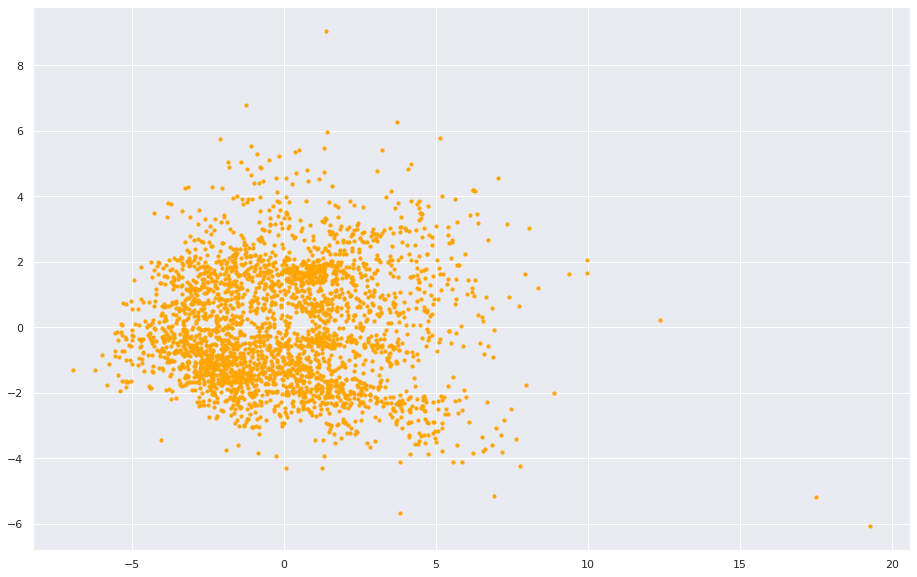

In [154]:
%matplotlib inline
plt.figure(figsize=(14,10))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c='orange', s=10);

*TSNE декомпозиция*

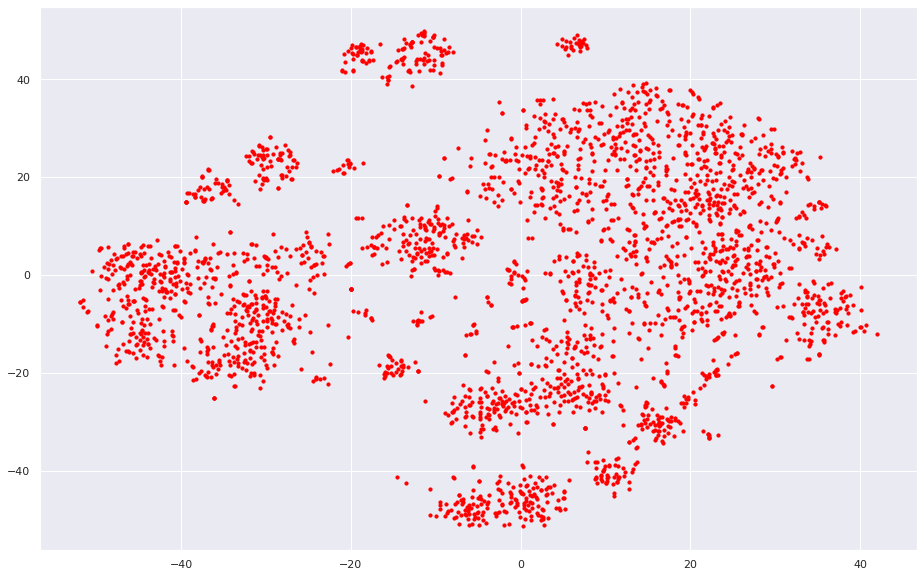

In [155]:
%matplotlib inline
plt.figure(figsize=(14,10))
plt.scatter(X_tsne2[:,0], X_tsne2[:,1], c='red', s=10);

*UMAP декомпозиция*

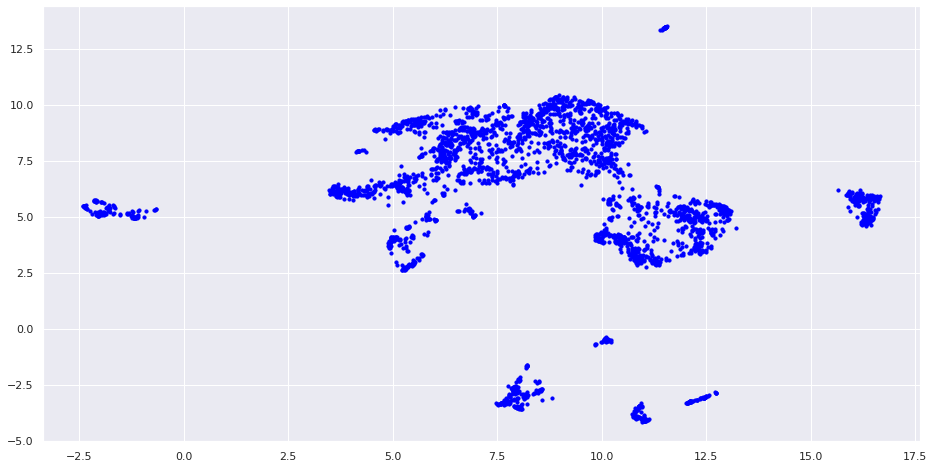

In [156]:
%matplotlib inline
plt.figure(figsize=(14,8))
plt.scatter(X_umap2[:,0], X_umap2[:,1], c='blue', s=10);

**Визуализация 3D данных**

<IPython.core.display.Javascript object>


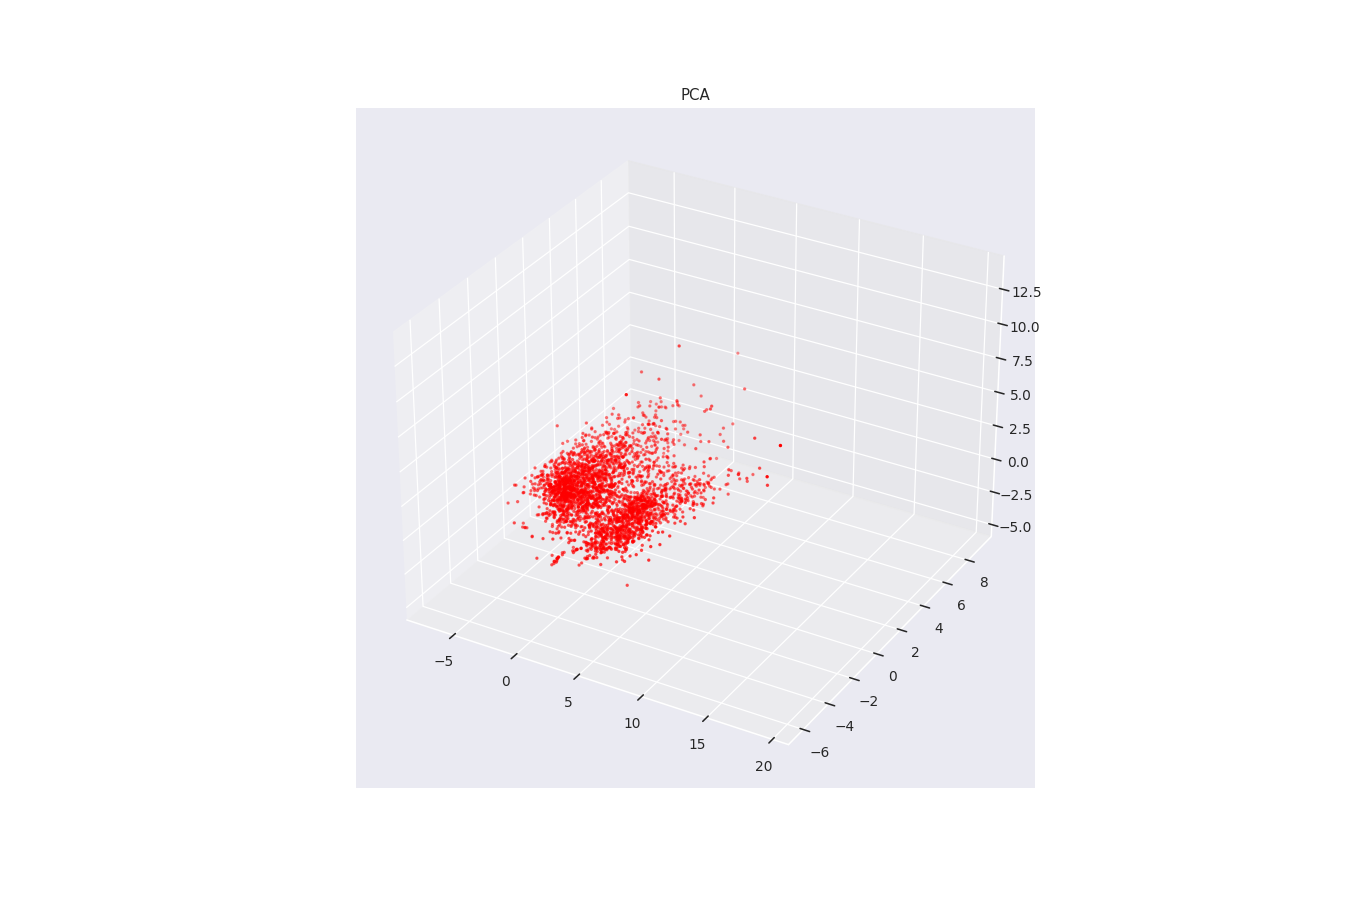

<IPython.core.display.Javascript object>


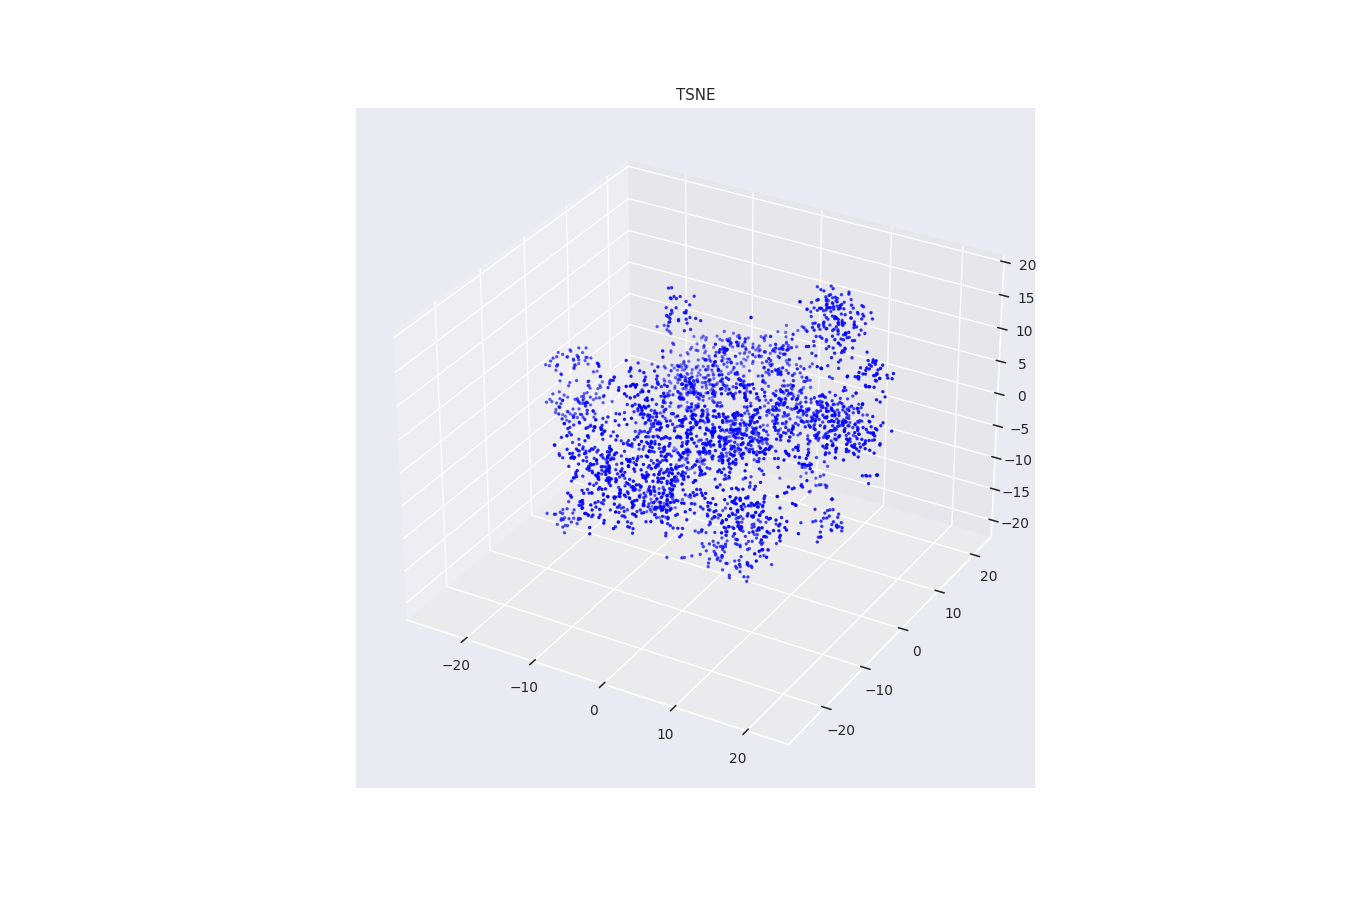

<IPython.core.display.Javascript object>


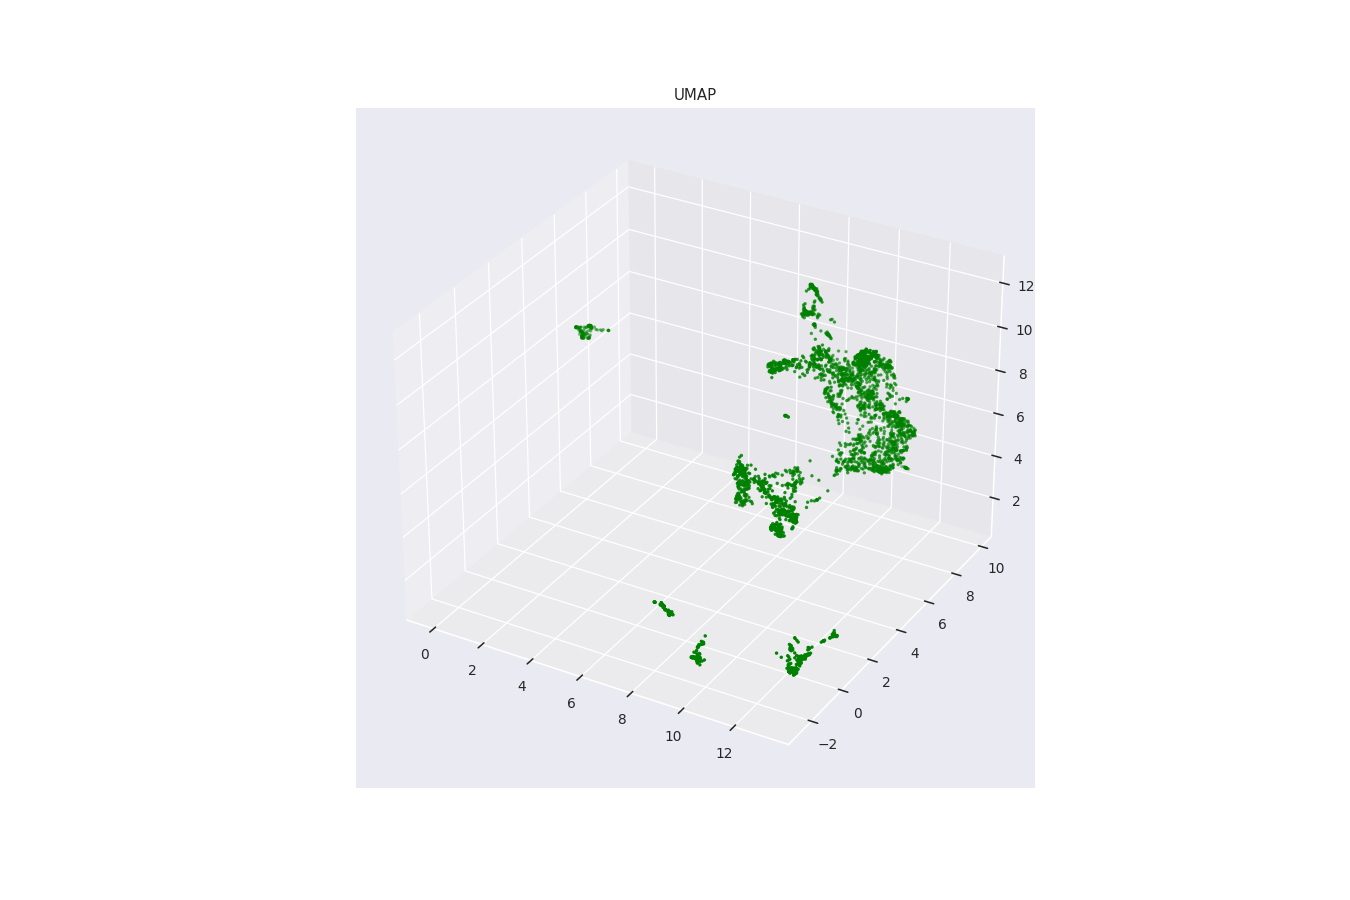

In [166]:
%matplotlib notebook
fig1 = plt.figure(figsize=(15, 10));
fig2 = plt.figure(figsize=(15, 10));
fig3 = plt.figure(figsize=(15, 10));

ax1 = fig1.add_subplot(111, projection='3d');
ax2 = fig2.add_subplot(111, projection='3d');
ax3 = fig3.add_subplot(111, projection='3d');

ax1.scatter(X_pca3[:,0], X_pca3[:,1], X_pca3[:,2], c='red', s=3);
ax2.scatter(X_tsne3[:,0], X_tsne3[:,1], X_tsne3[:,2], c='blue', s=3);
ax3.scatter(X_umap3[:,0], X_umap3[:,1], X_umap3[:,2], c='green', s=3);
ax1.set_title('PCA');
ax2.set_title('TSNE');
ax3.set_title('UMAP');

*Метрика Silhouette score*

In [167]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [168]:
# Ещё раз нормируем
X_pca_norm = StandardScaler().fit_transform(X_pca2)
X_tsne_norm = StandardScaler().fit_transform(X_tsne2)
X_umap_norm = StandardScaler().fit_transform(X_umap2)

In [169]:
X_pca_norm3 = StandardScaler().fit_transform(X_pca3)
X_tsne_norm3 = StandardScaler().fit_transform(X_tsne3)
X_umap_norm3 = StandardScaler().fit_transform(X_umap3)

**Метод кластеризации DBSCAN**

**2D**

-1      60
 0    2859
Name: 0, dtype: int64
-1     105
 0     567
 1     144
 2    1595
 3      33
 4     115
 5     169
 6      26
 7     116
 8      49
Name: 0, dtype: int64
-1      35
 0    2290
 1     159
 2      32
 3     120
 4     164
 5      49
 6      70
Name: 0, dtype: int64


<IPython.core.display.Javascript object>


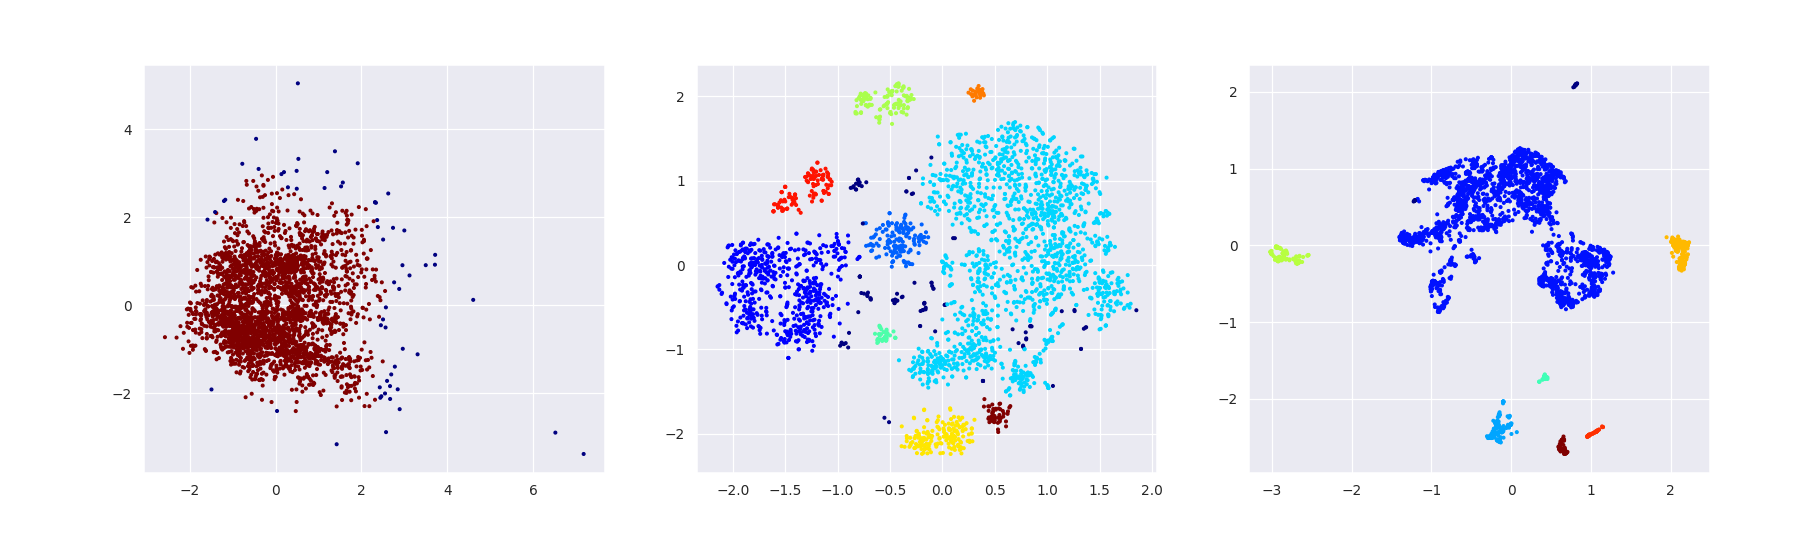

In [170]:
from sklearn.cluster import DBSCAN

dbscan_pca2 = DBSCAN(eps=0.5, min_samples=30)
dbscan_tsne2 = DBSCAN(eps=0.15, min_samples=15)
dbscan_umap2 = DBSCAN(eps=0.2, min_samples=30)

y_pca_2_db = dbscan_pca2.fit_predict(X_pca_norm)
y_tsne_2_db = dbscan_tsne2.fit_predict(X_tsne_norm)
y_umap_2_db = dbscan_umap2.fit_predict(X_umap_norm)
    
print(pd.DataFrame(y_pca_2_db)[0].value_counts().sort_index())
print(pd.DataFrame(y_tsne_2_db)[0].value_counts().sort_index())
print(pd.DataFrame(y_umap_2_db)[0].value_counts().sort_index())

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.scatter(X_pca_norm[:,0], X_pca_norm[:, 1], c=y_pca_2_db, cmap='jet', s=5);
ax2.scatter(X_tsne_norm[:,0], X_tsne_norm[:, 1], c=y_tsne_2_db, cmap='jet', s=5);
ax3.scatter(X_umap_norm[:,0], X_umap_norm[:, 1], c=y_umap_2_db, cmap='jet', s=5);

In [171]:
print(f'Для метода DBSCAN с использованием декомпозиции PCA Silhouette Score={silhouette_score(X_pca_norm, y_pca_2_db)}')
print(f'Для метода DBSCAN с использованием декомпозиции TSNE Silhouette Score={silhouette_score(X_tsne_norm, y_tsne_2_db)}')
print(f'Для метода DBSCAN с использованием декомпозиции UMAP Silhouette Score={silhouette_score(X_umap_norm, y_pca_2_db)}')

Для метода DBSCAN с использованием декомпозиции PCA Silhouette Score=0.49653277274253765
Для метода DBSCAN с использованием декомпозиции TSNE Silhouette Score=0.14488494396209717
Для метода DBSCAN с использованием декомпозиции UMAP Silhouette Score=0.16406674683094025


**3D**

-1    1642
 0     830
 1     280
 2      64
 3     103
Name: 0, dtype: int64
-1    2607
 0     142
 1     170
Name: 0, dtype: int64
-1     156
 0    2288
 1     191
 2     119
 3     165
Name: 0, dtype: int64


<IPython.core.display.Javascript object>


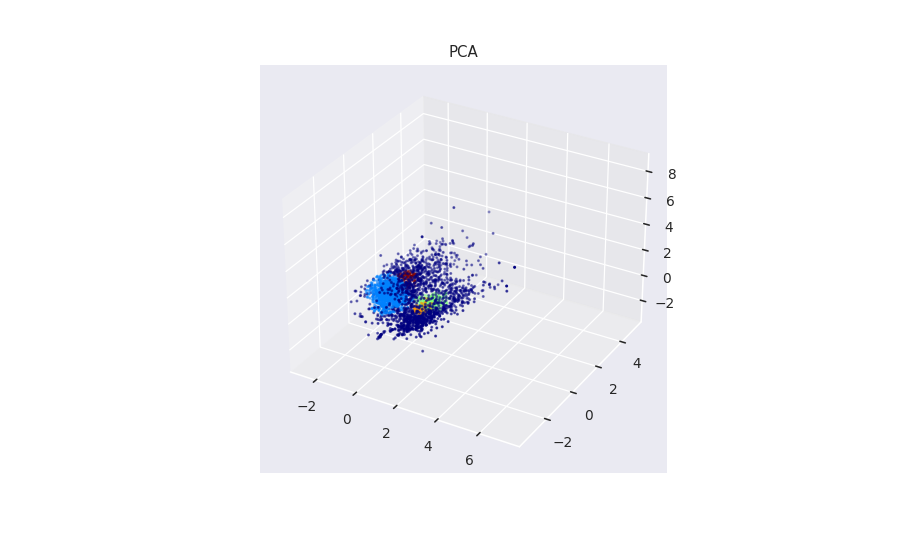

<IPython.core.display.Javascript object>


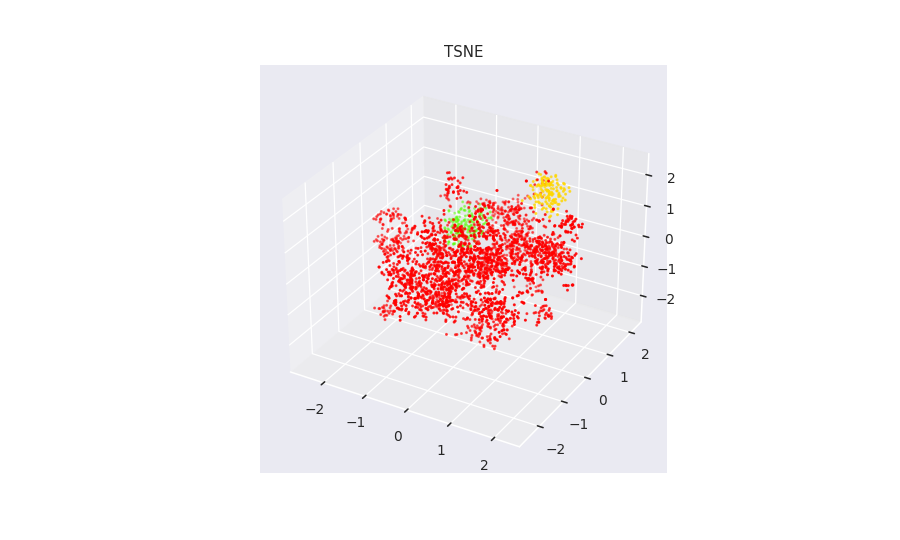

<IPython.core.display.Javascript object>


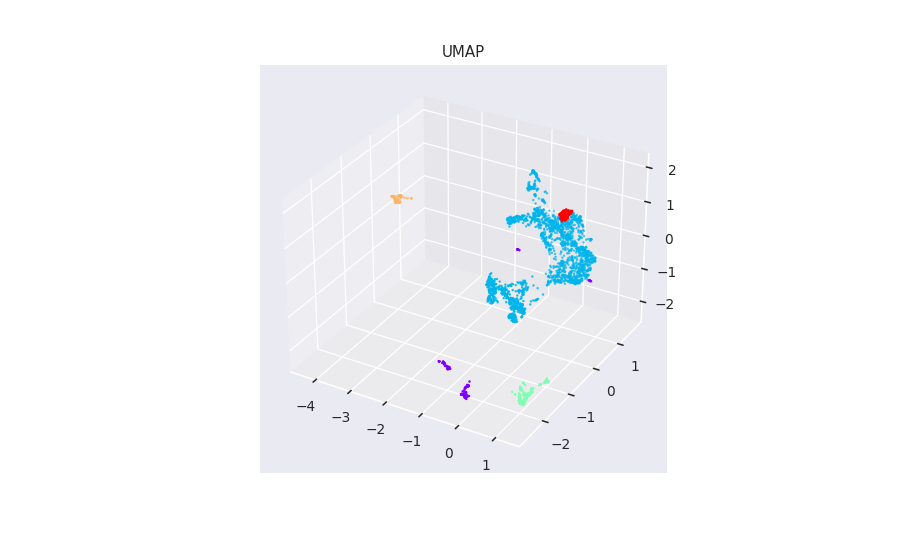

In [184]:
# Models
dbscan_pca3 = DBSCAN(eps=0.5, min_samples=100)
dbscan_tsne3 = DBSCAN(eps=0.5, min_samples=100)
dbscan_umap3 = DBSCAN(eps=0.5, min_samples=100)
#Обучение
y_pca_3_db = dbscan_pca3.fit_predict(X_pca_norm3)
y_tsne_3_db = dbscan_tsne3.fit_predict(X_tsne_norm3)
y_umap_3_db = dbscan_umap3.fit_predict(X_umap_norm3)
#Вывод кластеров
print(pd.DataFrame(y_pca_3_db)[0].value_counts().sort_index())
print(pd.DataFrame(y_tsne_3_db)[0].value_counts().sort_index())
print(pd.DataFrame(y_umap_3_db)[0].value_counts().sort_index())

#Графики
%matplotlib notebook
fig1 = plt.figure(figsize=(10, 6))
fig2 = plt.figure(figsize=(10, 6)) 
fig3 = plt.figure(figsize=(10, 6))

ax1 = fig1.add_subplot(111, projection='3d')
ax2 = fig2.add_subplot(111, projection='3d')
ax3 = fig3.add_subplot(111, projection='3d')

ax1.scatter(X_pca_norm3[:,0], X_pca_norm3[:,1], X_pca_norm3[:,2], c=y_pca_3_db, cmap='jet', s = 2);
ax2.scatter(X_tsne_norm3[:,0], X_tsne_norm3[:,1], X_tsne_norm3[:,2], c=y_tsne_3_db, cmap='prism', s = 2);
ax3.scatter(X_umap_norm3[:,0], X_umap_norm3[:,1], X_umap_norm3[:,2], c=y_umap_3_db, cmap='rainbow', s = 1);
ax1.set_title('PCA');
ax2.set_title('TSNE');
ax3.set_title('UMAP');

In [185]:
print(f'Для метода DBSCAN с использованием декомпозиции PCA Silhouette Score={silhouette_score(X_pca_norm3, y_pca_3_db)}')
print(f'Для метода DBSCAN с использованием декомпозиции TSNE Silhouette Score={silhouette_score(X_tsne_norm3, y_tsne_3_db)}')
print(f'Для метода DBSCAN с использованием декомпозиции UMAP Silhouette Score={silhouette_score(X_umap_norm3, y_pca_3_db)}')

Для метода DBSCAN с использованием декомпозиции PCA Silhouette Score=-0.09109604935452718
Для метода DBSCAN с использованием декомпозиции TSNE Silhouette Score=0.017853349447250366
Для метода DBSCAN с использованием декомпозиции UMAP Silhouette Score=-0.11607694625854492


*Вывод*

*Используя DBSCAN, мы не можем поделить независимые переменные на группы, и, следовательно, сократить количество признаков*

**Метод кластеризации KMeans**

*Метод локтя для нахождения оптимального количества кластеров*

In [186]:
from sklearn.cluster import KMeans

In [187]:
# Используем X с размерностью 2 PCA
wcss = []
for i in range(1, 20):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(X_pca_norm)
    wcss.append(km.inertia_)

<IPython.core.display.Javascript object>


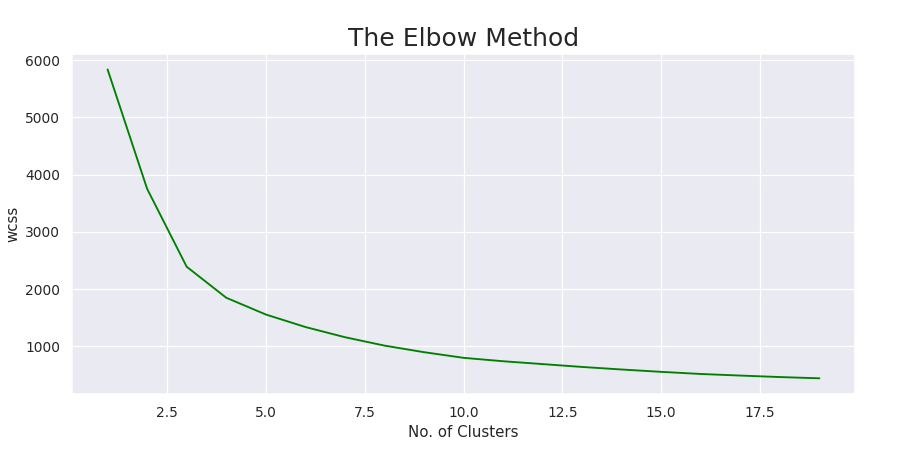

In [188]:
plt.plot(range(1, 20), wcss, c='green')
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

*Вывод - для X_pca_norm оптимальное количество кластеров примерно 7*

<IPython.core.display.Javascript object>


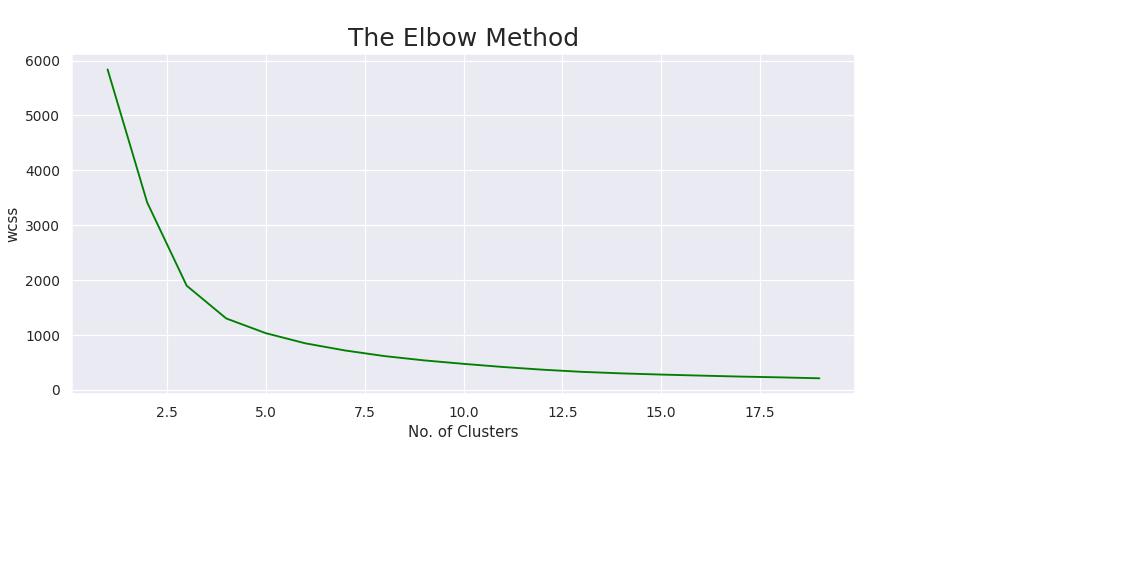

In [189]:
# Используем X с размерностью 2 TSNE
wcss = []
for i in range(1, 20):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(X_tsne_norm)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 20), wcss, c='green')
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

*Вывод - для X_tsne_norm оптимальное количество кластеров примерно 5*

<IPython.core.display.Javascript object>


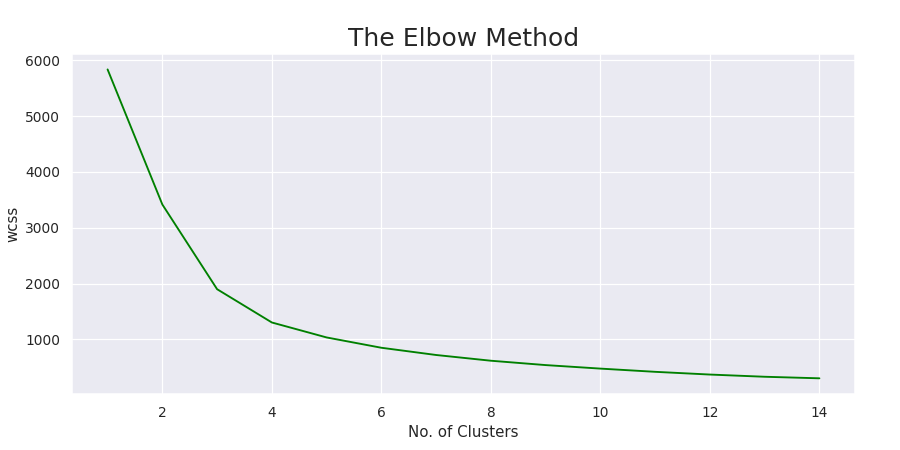

In [190]:
# Используем X с размерностью 2 UMAP
wcss = []
for i in range(1, 15):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(X_tsne_norm)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 15), wcss, c='green')
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

*Вывод - для X_umap_norm оптимальное количество кластеров примерно 4*

<IPython.core.display.Javascript object>


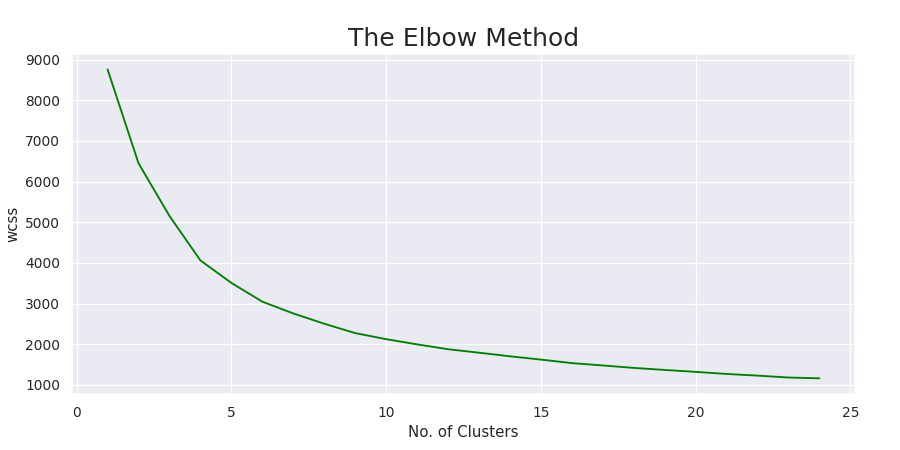

In [191]:
# Используем X с размерностью 3 PCA
wcss = []
for i in range(1, 25):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(X_pca_norm3)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 25), wcss, c='green')
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

*Вывод - для X_pca_norm3 оптимальное количество кластеров примерно 6*

<IPython.core.display.Javascript object>


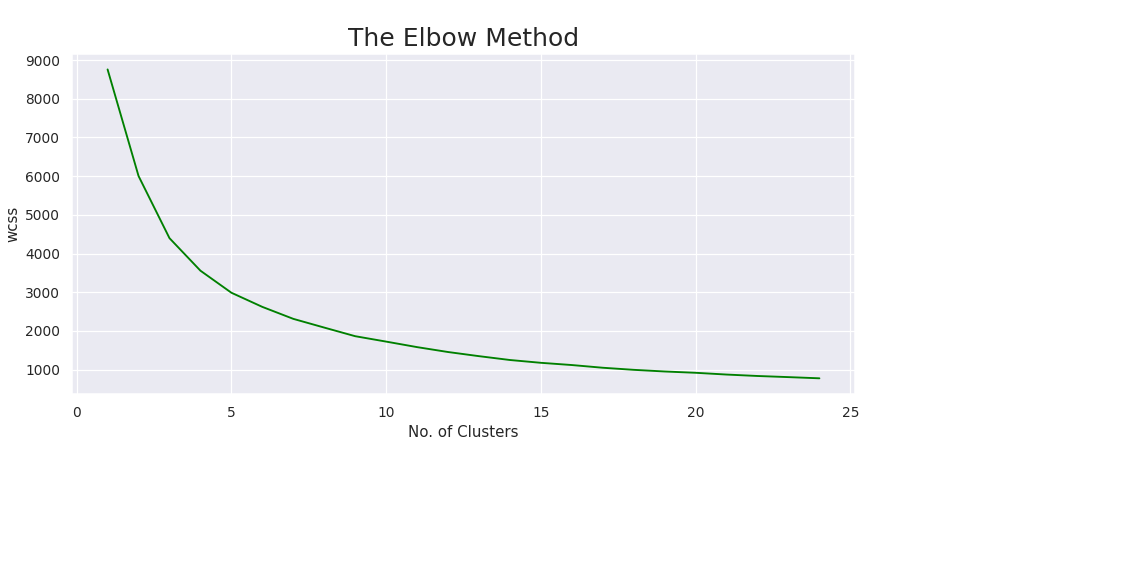

In [195]:
# Используем X с размерностью 3 TSNE
wcss = []
for i in range(1, 25):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(X_tsne_norm3)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 25), wcss, c='green')
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

*Вывод - для X_tsne_norm3 оптимальное количество кластеров примерно 6*


<IPython.core.display.Javascript object>


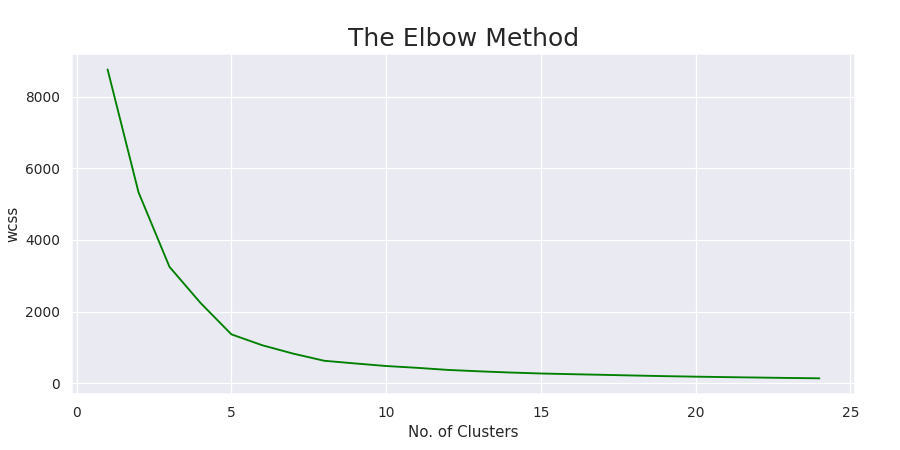

In [196]:
# Используем X с размерностью 3 UMAP
wcss = []
for i in range(1, 25):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(X_umap_norm3)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 25), wcss, c='green')
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

*Вывод - для X_umap_norm3 оптимальное количество кластеров примерно 5*


**2D**

0    460
1    538
2    444
3    429
4    623
5    242
6    183
Name: 0, dtype: int64
0    650
1    597
2    619
3    624
4    429
Name: 0, dtype: int64
0     749
1    1305
2     310
3     555
Name: 0, dtype: int64


<IPython.core.display.Javascript object>


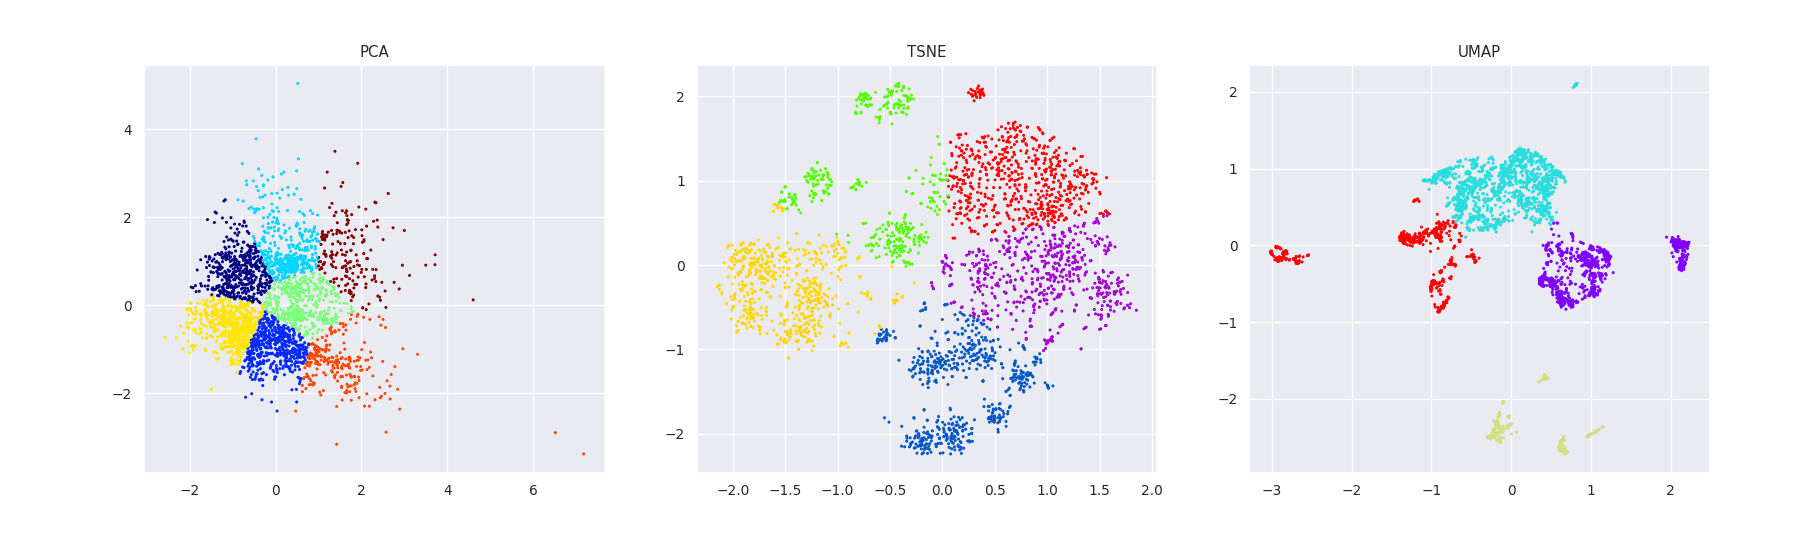

In [197]:
kmeans_pca2 = KMeans(n_clusters=7, max_iter=300, n_init=10)
kmeans_tsne2 = KMeans(n_clusters=5, max_iter=300, n_init=10)
kmeans_umap2 = KMeans(n_clusters=4, max_iter=300, n_init=10)
#Обучение
y_pca_2_km = kmeans_pca2.fit_predict(X_pca_norm)
y_tsne_2_km = kmeans_tsne2.fit_predict(X_tsne_norm)
y_umap_2_km = kmeans_umap2.fit_predict(X_umap_norm)
#Вывод кластеров
print(pd.DataFrame(y_pca_2_km)[0].value_counts().sort_index())
print(pd.DataFrame(y_tsne_2_km)[0].value_counts().sort_index())
print(pd.DataFrame(y_umap_2_km)[0].value_counts().sort_index())

#Графики
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.scatter(X_pca_norm[:,0], X_pca_norm[:,1], c=y_pca_2_km, cmap='jet', s = 2);
ax2.scatter(X_tsne_norm[:,0], X_tsne_norm[:,1], c=y_tsne_2_km, cmap='prism', s = 2);
ax3.scatter(X_umap_norm[:,0], X_umap_norm[:,1], c=y_umap_2_km, cmap='rainbow', s = 2);
ax1.set_title('PCA');
ax2.set_title('TSNE');
ax3.set_title('UMAP');

In [198]:
print(f'Для метода Kmeans с использованием декомпозиции PCA Silhouette Score={silhouette_score(X_pca_norm, y_pca_2_km)}')
print(f'Для метода Kmeans с использованием декомпозиции TSNE Silhouette Score={silhouette_score(X_tsne_norm, y_tsne_2_km)}')
print(f'Для метода Kmeans с использованием декомпозиции UMAP Silhouette Score={silhouette_score(X_umap_norm, y_pca_2_km)}')

Для метода Kmeans с использованием декомпозиции PCA Silhouette Score=0.34210190044958033
Для метода Kmeans с использованием декомпозиции TSNE Silhouette Score=0.4306531846523285
Для метода Kmeans с использованием декомпозиции UMAP Silhouette Score=-0.07125694304704666


**3D**

0    481
1    939
2    331
3    232
4    485
5    451
Name: 0, dtype: int64
0    475
1    556
2    683
3    326
4    379
5    500
Name: 0, dtype: int64
0    1016
1     119
2     310
3     894
4     580
Name: 0, dtype: int64


<IPython.core.display.Javascript object>


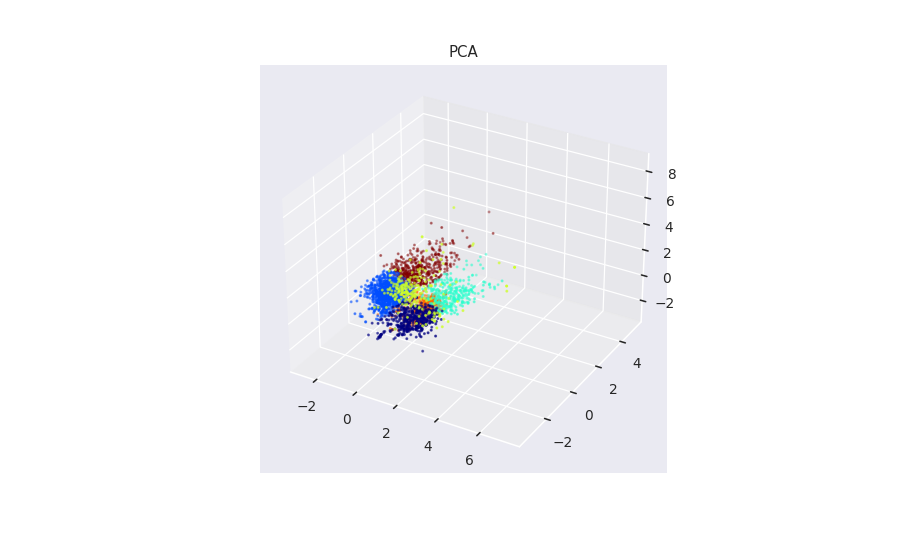

<IPython.core.display.Javascript object>


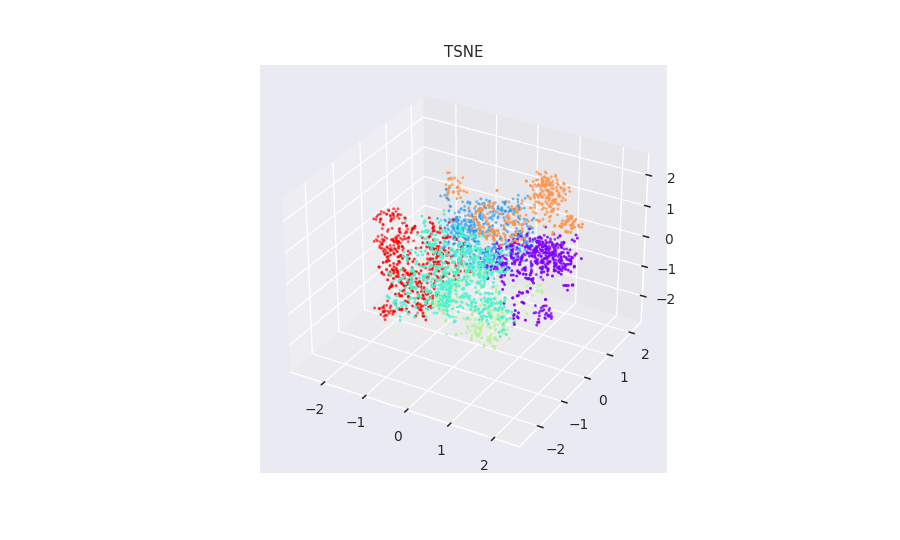

<IPython.core.display.Javascript object>


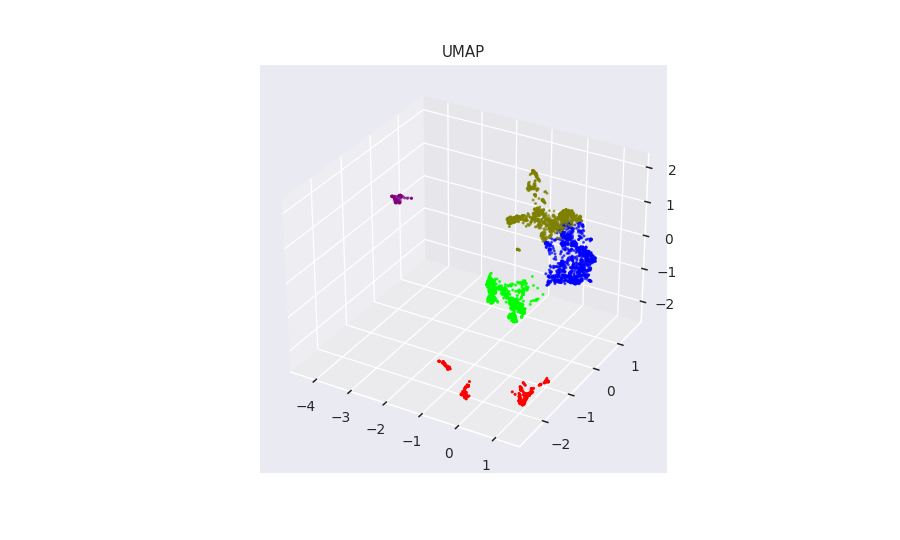

In [200]:
kmeans_pca3 = KMeans(n_clusters=6, max_iter=300, n_init=10)
kmeans_tsne3 = KMeans(n_clusters=6, max_iter=300, n_init=10)
kmeans_umap3 = KMeans(n_clusters=5, max_iter=300, n_init=10)

y_pca_3_km = kmeans_pca3.fit_predict(X_pca_norm3)
y_tsne_3_km = kmeans_tsne3.fit_predict(X_tsne_norm3)
y_umap_3_km = kmeans_umap3.fit_predict(X_umap_norm3)

print(pd.DataFrame(y_pca_3_km)[0].value_counts().sort_index())
print(pd.DataFrame(y_tsne_3_km)[0].value_counts().sort_index())
print(pd.DataFrame(y_umap_3_km)[0].value_counts().sort_index())

%matplotlib notebook
fig1 = plt.figure(figsize=(10, 6))
fig2 = plt.figure(figsize=(10, 6)) 
fig3 = plt.figure(figsize=(10, 6))

ax1 = fig1.add_subplot(111, projection='3d')
ax2 = fig2.add_subplot(111, projection='3d')
ax3 = fig3.add_subplot(111, projection='3d')

ax1.scatter(X_pca_norm3[:, 0], X_pca_norm3[:, 1], X_pca_norm3[:, 2], c=y_pca_3_km, cmap='jet', s=2);
ax2.scatter(X_tsne_norm3[:, 0], X_tsne_norm3[:, 1], X_tsne_norm3[:, 2], c=y_tsne_3_km, cmap='rainbow', s=2);
ax3.scatter(X_umap_norm3[:, 0], X_umap_norm3[:, 1], X_umap_norm3[:, 2], c=y_umap_3_km, cmap='brg', s=2);

ax1.set_title('PCA');
ax2.set_title('TSNE');
ax3.set_title('UMAP');

In [201]:
print(f'Для метода Kmeans с использованием декомпозиции PCA Silhouette Score={silhouette_score(X_pca_norm3, y_pca_3_km):.2f}')
print(f'Для метода Kmeans с использованием декомпозиции TSNE Silhouette Score={silhouette_score(X_tsne_norm3, y_tsne_3_km):.2f}')
print(f'Для метода Kmeans с использованием декомпозиции UMAP Silhouette Score={silhouette_score(X_umap_norm3, y_pca_3_km):.2f}')

Для метода Kmeans с использованием декомпозиции PCA Silhouette Score=0.32
Для метода Kmeans с использованием декомпозиции TSNE Silhouette Score=0.30
Для метода Kmeans с использованием декомпозиции UMAP Silhouette Score=0.04


*Вывод*

*Используя KMeans, мы не можем поделить независимые переменные на группы, и, следовательно, сократить количество признаков*

# Permutation Importance – метод, широко используемый для вычисления важности признаков

*Загрузим библиотеку eli5 и воспользуемся permutation importance на обученой модели ElasticNet*

In [131]:
import eli5
from eli5.sklearn import PermutationImportance

perm=PermutationImportance(best_model5, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.0920 ± 0.0190,OverallQual
0.0534 ± 0.0145,2ndFlrSF
0.0438 ± 0.0138,1stFlrSF
0.0227 ± 0.0026,GarageCars
0.0197 ± 0.0042,YearBuilt
0.0173 ± 0.0079,OverallCond
0.0127 ± 0.0057,GrLivArea
0.0126 ± 0.0034,BsmtFullBath
0.0124 ± 0.0038,MSZoning_RL
0.0105 ± 0.0015,MSSubClass


*Преобразуем таблицу в DataFrame*

In [132]:
feature_weights = eli5.explain_weights_df(perm, feature_names=X_test.columns.tolist())

*Выделим колонки с наименьшим весом и удалим из изначального датасета для дальнейшего анализа*

In [133]:
useless_columns = feature_weights[feature_weights['weight'] < 0.0001]['feature'].tolist()

In [134]:
print(*useless_columns, sep=', ')

FireplaceQu_Po, GarageQual_Gd, GarageCond_TA, Condition1_RRAe, GarageType_BuiltIn, RoofStyle_Hip, Exterior2nd_Brk Cmn, RoofStyle_Mansard, Neighborhood_Timber, Exterior1st_HdBoard, FireplaceQu_Fa, FireplaceQu_TA, Functional_Mod, Neighborhood_CollgCr, BldgType_TwnhsE, Heating_OthW, Neighborhood_Sawyer, BsmtFinType2_Rec, SaleCondition_Alloca, Neighborhood_SWISU, Neighborhood_Gilbert, Neighborhood_SawyerW, Neighborhood_Blueste, Exterior2nd_Stone, Neighborhood_NPkVill, ExterQual_Fa, MoSold, Foundation_Stone, Heating_Wall, BsmtExposure_Mn, Exterior1st_Stone, SaleType_nan, Condition2_PosN, SaleType_ConLw, SaleCondition_AdjLand, Condition2_Feedr, Condition2_RRAn, Condition1_RRNe, Condition2_nan, Condition1_RRNn, Condition1_nan, SaleType_Oth, Condition2_RRAe, Condition2_PosA, GarageCond_Gd, Neighborhood_nan, PoolArea, Alley_nan, MSZoning_nan, LandContour_nan, GarageCond_Po, BldgType_nan, LotConfig_FR3, LotConfig_nan, GarageCond_nan, GarageType_nan, GarageQual_nan, PavedDrive_nan, Fence_nan, Sal

*X - независимые переменные, y - таргет*

In [135]:
X.drop(columns=useless_columns)

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageCond_Fa,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnWw,SaleType_ConLD,SaleType_New,SaleType_WD,SaleCondition_Normal,SaleCondition_Partial
0,0.067331,8450,0.646183,-0.507284,18,18,0.0,150.0,856.0,856,...,0,0,1,0,0,0,0,1,1,0
1,-0.873616,9600,-0.063185,2.188279,45,45,0.0,284.0,1262.0,1262,...,0,0,1,0,0,0,0,1,1,0
2,0.067331,11250,0.646183,-0.507284,20,19,0.0,434.0,920.0,920,...,0,0,1,0,0,0,0,1,1,0
3,0.302568,9550,0.646183,-0.507284,106,51,0.0,540.0,756.0,961,...,0,0,1,0,0,0,0,1,0,0
4,0.067331,14260,1.355551,-0.507284,21,21,0.0,490.0,1145.0,1145,...,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.067331,7917,-0.063185,-0.507284,22,21,0.0,953.0,953.0,953,...,0,0,1,0,0,0,0,1,1,0
1456,-0.873616,13175,-0.063185,0.391237,43,33,163.0,589.0,1542.0,2073,...,0,0,1,0,0,0,0,1,1,0
1457,0.302568,9042,0.646183,3.086800,80,15,0.0,877.0,1152.0,1188,...,0,0,1,0,0,0,0,1,1,0
1458,-0.873616,9717,-0.772552,0.391237,71,25,1029.0,0.0,1078.0,1078,...,0,0,1,0,0,0,0,1,1,0


**Train Test Split**

In [136]:
from sklearn.model_selection import train_test_split
X_trainP, X_testP, y_trainP, y_testP = train_test_split(X, y, test_size=0.20)

*Обучим ElasticNet на новых данных и сравним результат*

In [137]:
clf = ElasticNet()

parameters = {'alpha':[0.01, 0.05, 0.1],
              'random_state': [1, None],
              'positive': [True, False],
              'selection' : ['cyclic', 'random'],
              'l1_ratio': [0, 0.2, 0.5],
              'max_iter': [500, 1000, 300],
              'warm_start': [True, False]
             }

cv12= GridSearchCV(clf, 
                  parameters, 
                  scoring='neg_mean_squared_error',
                  cv=5, 
                  refit=True, 
                  n_jobs=-1)

In [138]:
cv12.fit(X_trainP, y_trainP)

/home/elena/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.623925985230386, tolerance: 0.037741346378134234
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.05, 0.1], 'l1_ratio': [0, 0.2, 0.5],
                         'max_iter': [500, 1000, 300],
                         'positive': [True, False], 'random_state': [1, None],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             scoring='neg_mean_squared_error')

In [139]:
cv12.best_params_, cv12.best_score_

({'alpha': 0.01,
  'l1_ratio': 0,
  'max_iter': 300,
  'positive': False,
  'random_state': None,
  'selection': 'random',
  'warm_start': False},
 -0.03390907812889006)

In [140]:
#предсказанные значения y для обучающей выборки
best_model12 = cv12.best_estimator_
y_pred_12 = best_model12.predict(X_testP)

In [141]:
cv12_results = pd.DataFrame(cv12.cv_results_)

In [142]:
#Среднеквадратичная ошибка
mse12 = mean_squared_error(y_testP, y_pred_12)
mse12

0.07215693219922685

In [143]:
#Среднеквадратичное отклонение
rmse12 = np.sqrt(mse12)
rmse12

0.2686204240172866

In [144]:
print(f'MSE = {mse5} до удаления незначимых признаков')
print(f'MSE = {mse12} после удаления незначимых признаков')

MSE = 0.03766845885061687 до удаления незначимых признаков
MSE = 0.07215693219922685 после удаления незначимых признаков


*Вывод - результат оказался чуть хуже*

*Проверим модель Ridge Linear Regression*

In [145]:
clf=Ridge()

parameters={'alpha':[15, 20, 25, 30],
            'solver' : ['auto', 'svd', 'lsqr', 'saga'],
            'random_state': [1, None],
            'normalize': [True, False],
            'fit_intercept': [True, False]
           }

cv13=GridSearchCV(clf, 
                 parameters, 
                 scoring='neg_mean_squared_error',
                 cv=5, 
                 refit=True, 
                 n_jobs=4)

In [146]:
cv13.fit(X_trainP, y_trainP)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=4,
             param_grid={'alpha': [15, 20, 25, 30],
                         'fit_intercept': [True, False],
                         'normalize': [True, False], 'random_state': [1, None],
                         'solver': ['auto', 'svd', 'lsqr', 'saga']},
             scoring='neg_mean_squared_error')

In [147]:
cv13.best_params_, cv13.best_score_

({'alpha': 15,
  'fit_intercept': True,
  'normalize': False,
  'random_state': 1,
  'solver': 'svd'},
 -0.03412311087168657)

In [148]:
#предсказанные значения y для обучающей выборки
best_model13 = cv13.best_estimator_
y_pred_13 = best_model13.predict(X_testP)

In [149]:
#Среднеквадратичная ошибка
mse13 = mean_squared_error(y_testP, y_pred_13)
mse13

0.07241687937249104

In [150]:
print(f'MSE = {mse5} до удаления незначимых признаков')
print(f'MSE = {mse13} после удаления незначимых признаков')

MSE = 0.03766845885061687 до удаления незначимых признаков
MSE = 0.07241687937249104 после удаления незначимых признаков


# Перекодируем в изначальном датасете категориальные переменные другим способом - Target Encoding

In [197]:
#df - датасет с неизмененными данными в категориальных переменных
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Grvl,Reg,Lvl,Inside,CollgCr,Norm,...,0,0,0,0,MnPrv,0,2,13,WD,Normal
1,20,RL,80.0,9600,Grvl,Reg,Lvl,FR2,Veenker,Feedr,...,0,0,0,0,MnPrv,0,5,14,WD,Normal
2,60,RL,68.0,11250,Grvl,IR1,Lvl,Inside,CollgCr,Norm,...,0,0,0,0,MnPrv,0,9,13,WD,Normal
3,70,RL,60.0,9550,Grvl,IR1,Lvl,Corner,Crawfor,Norm,...,272,0,0,0,MnPrv,0,2,15,WD,Abnorml
4,60,RL,84.0,14260,Grvl,IR1,Lvl,FR2,NoRidge,Norm,...,0,0,0,0,MnPrv,0,12,13,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Grvl,Reg,Lvl,Inside,MeadowV,Norm,...,0,0,0,0,MnPrv,0,6,15,WD,Normal
1455,160,RM,21.0,1894,Grvl,Reg,Lvl,Inside,MeadowV,Norm,...,0,0,0,0,MnPrv,0,4,15,WD,Abnorml
1456,20,RL,160.0,20000,Grvl,Reg,Lvl,Inside,Mitchel,Norm,...,0,0,0,0,MnPrv,0,9,15,WD,Abnorml
1457,85,RL,62.0,10441,Grvl,Reg,Lvl,Inside,Mitchel,Norm,...,0,0,0,0,MnPrv,700,7,15,WD,Normal


In [198]:
data = df.copy()

**Стандартизируем дискретные переменные**

In [199]:
data[dis] = scaler.fit_transform(data[dis])

**Раделим df на train и test и добавим SalePrice**

In [200]:
train = data.iloc[0:df_train.shape[0]]
test = data.iloc[train.shape[0]:]
train.shape, test.shape, df_train.shape, df_test.shape

((1460, 74), (1459, 74), (1460, 74), (1459, 74))

In [201]:
# добавим у к train
train=pd.concat([train, y], axis=1)
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0.067331,RL,65.0,8450,Grvl,Reg,Lvl,Inside,CollgCr,Norm,...,0,0,-0.06315,MnPrv,0,-1.552184,-0.157646,WD,Normal,17.669688
1,-0.873616,RL,80.0,9600,Grvl,Reg,Lvl,FR2,Veenker,Feedr,...,0,0,-0.06315,MnPrv,0,-0.446925,0.602962,WD,Normal,17.469610
2,0.067331,RL,68.0,11250,Grvl,IR1,Lvl,Inside,CollgCr,Norm,...,0,0,-0.06315,MnPrv,0,1.026753,-0.157646,WD,Normal,17.769915
3,0.302568,RL,60.0,9550,Grvl,IR1,Lvl,Corner,Crawfor,Norm,...,0,0,-0.06315,MnPrv,0,-1.552184,1.363569,WD,Abnorml,17.095067
4,0.067331,RL,84.0,14260,Grvl,IR1,Lvl,FR2,NoRidge,Norm,...,0,0,-0.06315,MnPrv,0,2.132012,-0.157646,WD,Normal,17.931569


In [202]:
# загружаем библиотеки
import pandas as pd
from category_encoders import TargetEncoder

In [203]:
encoder = TargetEncoder()

In [204]:
df_target = encoder.fit_transform(train, y)

/home/elena/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


**Получившиеся датасет после преобразования категориальных данных**

In [206]:
df_target

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0.067331,17.436246,65.0,8450,17.348174,17.220143,17.345081,17.315081,17.548425,17.374255,...,0,0,-0.06315,17.361616,0,-1.552184,-0.157646,17.299444,17.319603,17.669688
1,-0.873616,17.436246,80.0,9600,17.348174,17.220143,17.345081,17.362462,17.808860,17.050252,...,0,0,-0.06315,17.361616,0,-0.446925,0.602962,17.299444,17.319603,17.469610
2,0.067331,17.436246,68.0,11250,17.348174,17.548171,17.345081,17.315081,17.548425,17.374255,...,0,0,-0.06315,17.361616,0,1.026753,-0.157646,17.299444,17.319603,17.769915
3,0.302568,17.436246,60.0,9550,17.348174,17.548171,17.345081,17.351936,17.610486,17.374255,...,0,0,-0.06315,17.361616,0,-1.552184,1.363569,17.299444,17.007606,17.095067
4,0.067331,17.436246,84.0,14260,17.348174,17.548171,17.345081,17.362462,18.287603,17.374255,...,0,0,-0.06315,17.361616,0,2.132012,-0.157646,17.299444,17.319603,17.931569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.067331,17.436246,62.0,7917,17.348174,17.220143,17.345081,17.315081,17.537117,17.374255,...,0,0,-0.06315,17.361616,0,0.658334,0.602962,17.299444,17.319603,17.416995
1456,-0.873616,17.436246,85.0,13175,17.348174,17.220143,17.345081,17.315081,17.500769,17.374255,...,0,0,-0.06315,17.361616,0,-1.552184,-1.678860,17.299444,17.319603,17.680030
1457,0.302568,17.436246,66.0,9042,17.348174,17.220143,17.345081,17.315081,17.610486,17.374255,...,0,0,-0.06315,17.394736,2500,-0.446925,-1.678860,17.299444,17.319603,18.023776
1458,-0.873616,17.436246,68.0,9717,17.348174,17.220143,17.345081,17.315081,17.121969,17.374255,...,0,0,-0.06315,17.361616,0,-0.815344,-1.678860,17.299444,17.319603,17.116801


In [214]:
for i in cat:
    test[i] = df_target[i]

<ipython-input-214-c3d04697a907>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i] = df_target[i]


In [215]:
test

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,-0.873616,17.436246,80.0,11622,17.348174,17.220143,17.345081,17.315081,17.548425,17.374255,...,0,0,120,-0.06315,17.361616,0,-0.078505,-1.678860,17.299444,17.319603
1,-0.873616,17.436246,81.0,14267,17.348174,17.220143,17.345081,17.362462,17.808860,17.050252,...,0,0,0,-0.06315,17.361616,12500,-0.078505,-1.678860,17.299444,17.319603
2,0.067331,17.436246,74.0,13830,17.348174,17.548171,17.345081,17.315081,17.548425,17.374255,...,0,0,0,-0.06315,17.361616,0,-1.183764,-1.678860,17.299444,17.319603
3,0.067331,17.436246,78.0,9978,17.348174,17.548171,17.345081,17.351936,17.610486,17.374255,...,0,0,0,-0.06315,17.361616,0,-0.078505,-1.678860,17.299444,17.007606
4,1.478753,17.436246,43.0,5005,17.348174,17.548171,17.345081,17.362462,18.287603,17.374255,...,0,0,144,-0.06315,17.361616,0,-1.920603,-1.678860,17.299444,17.319603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419700,17.668132,21.0,1936,17.307741,17.220143,17.345081,17.315081,17.740093,17.374255,...,0,0,0,-0.06315,17.361616,0,-0.078505,1.363569,17.299444,17.319603
1455,2.419700,17.436246,21.0,1894,17.348174,17.220143,17.345081,17.315081,17.537117,17.374255,...,0,0,0,-0.06315,17.361616,0,-0.815344,1.363569,17.299444,17.319603
1456,-0.873616,17.436246,160.0,20000,17.348174,17.220143,17.345081,17.315081,17.500769,17.374255,...,0,0,0,-0.06315,17.361616,0,1.026753,1.363569,17.299444,17.319603
1457,0.655424,17.436246,62.0,10441,17.348174,17.220143,17.345081,17.315081,17.610486,17.374255,...,0,0,0,-0.06315,17.394736,700,0.289914,1.363569,17.299444,17.319603


**X и y**

In [216]:
# Независимые переменные
X=df_target.drop(['SalePrice'],axis=1)

In [217]:
y

0       17.669688
1       17.469610
2       17.769915
3       17.095067
4       17.931569
          ...    
1455    17.416995
1456    17.680030
1457    18.023776
1458    17.116801
1459    17.170355
Name: SalePrice, Length: 1460, dtype: float64

**Train Test Split**

In [218]:
from sklearn.model_selection import train_test_split
X_trainT, X_testT, y_trainT, y_testT = train_test_split(X, y, test_size=0.20)

In [219]:
# Проверим модель Ridge Linear Regression

clf=Ridge()

parameters={'alpha':[15, 20, 25, 30],
            'solver' : ['auto', 'svd', 'lsqr', 'saga'],
            'random_state': [1, None],
            'normalize': [True, False],
            'fit_intercept': [True, False]
           }

cv14=GridSearchCV(clf, 
                 parameters, 
                 scoring='neg_mean_squared_error',
                 cv=5, 
                 refit=True, 
                 n_jobs=4)

In [220]:
cv14.fit(X_trainT, y_trainT)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=4,
             param_grid={'alpha': [15, 20, 25, 30],
                         'fit_intercept': [True, False],
                         'normalize': [True, False], 'random_state': [1, None],
                         'solver': ['auto', 'svd', 'lsqr', 'saga']},
             scoring='neg_mean_squared_error')

In [221]:
cv14.best_params_, cv14.best_score_

({'alpha': 15,
  'fit_intercept': True,
  'normalize': False,
  'random_state': 1,
  'solver': 'svd'},
 -0.04696516342503909)

In [222]:
#Предсказанные значения y для обучающей выборки
best_model14 = cv14.best_estimator_
y_pred_14 = best_model14.predict(X_testT)

In [223]:
#Среднеквадратичная ошибка
mse14 = mean_squared_error(y_testT, y_pred_14)
mse14

0.028187321785883613

*Результат оказался хуже всех для этой модели*

**Попробуем с помощью Permutation Importance удалить часть категориальных данных**

In [224]:
import eli5
from eli5.sklearn import PermutationImportance

perm=PermutationImportance(best_model14, random_state=1).fit(X_testT, y_testT)
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.0873 ± 0.0118,OverallQual
0.0705 ± 0.0110,GrLivArea
0.0544 ± 0.0122,Neighborhood
0.0332 ± 0.0088,OverallCond
0.0324 ± 0.0120,GarageCars
0.0128 ± 0.0036,BsmtFullBath
0.0100 ± 0.0025,MSZoning
0.0092 ± 0.0012,Fireplaces
0.0089 ± 0.0013,1stFlrSF
0.0084 ± 0.0023,YearBuilt


In [225]:
feature_weights = eli5.explain_weights_df(perm, feature_names=X.columns.tolist())

In [226]:
useless_columns = feature_weights[feature_weights['weight'] < 0.0001]['feature'].tolist()

In [227]:
print(*useless_columns)

PoolArea BsmtCond ExterCond FireplaceQu BsmtHalfBath LotShape BsmtFinType2 MasVnrType MasVnrArea MoSold GarageType Alley Exterior2nd BldgType MiscVal Fence BsmtUnfSF Electrical Condition2 SaleType LotFrontage


In [228]:
X.drop(columns=useless_columns)

,MSSubClass,MSZoning,LotArea,LandContour,LotConfig,Neighborhood,Condition1,HouseStyle,OverallQual,OverallCond,...,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,YrSold,SaleCondition
0,0.067331,17.436246,8450,17.345081,17.315081,17.548425,17.374255,17.575901,0.646183,-0.507284,...,17.362811,17.36597,17.39875,0,61,0,0,0,-0.157646,17.319603
1,-0.873616,17.436246,9600,17.345081,17.362462,17.808860,17.050252,17.303227,-0.063185,2.188279,...,17.362811,17.36597,17.39875,298,0,0,0,0,0.602962,17.319603
2,0.067331,17.436246,11250,17.345081,17.315081,17.548425,17.374255,17.575901,0.646183,-0.507284,...,17.362811,17.36597,17.39875,0,42,0,0,0,-0.157646,17.319603
3,0.302568,17.436246,9550,17.345081,17.351936,17.610486,17.374255,17.575901,0.646183,-0.507284,...,17.362811,17.36597,17.39875,0,35,272,0,0,1.363569,17.007606
4,0.067331,17.436246,14260,17.345081,17.362462,18.287603,17.374255,17.575901,1.355551,-0.507284,...,17.362811,17.36597,17.39875,192,84,0,0,0,-0.157646,17.319603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.067331,17.436246,7917,17.345081,17.315081,17.537117,17.374255,17.575901,-0.063185,-0.507284,...,17.362811,17.36597,17.39875,0,40,0,0,0,0.602962,17.319603
1456,-0.873616,17.436246,13175,17.345081,17.315081,17.500769,17.374255,17.303227,-0.063185,0.391237,...,17.362811,17.36597,17.39875,349,0,0,0,0,-1.678860,17.319603
1457,0.302568,17.436246,9042,17.345081,17.315081,17.610486,17.374255,17.575901,0.646183,3.086800,...,17.362811,17.36597,17.39875,0,60,0,0,0,-1.678860,17.319603
1458,-0.873616,17.436246,9717,17.345081,17.315081,17.121969,17.374255,17.303227,-0.772552,0.391237,...,17.362811,17.36597,17.39875,366,0,112,0,0,-1.678860,17.319603


In [229]:
from sklearn.model_selection import train_test_split
X_trainTP, X_testTP, y_trainTP, y_testTP = train_test_split(X, y, test_size=0.20)

In [230]:
clf=Ridge()

parameters={'alpha':[15, 20, 25, 30],
            'solver' : ['auto', 'svd', 'lsqr', 'saga'],
            'random_state': [1, None],
            'normalize': [True, False],
            'fit_intercept': [True, False]
           }

cv15=GridSearchCV(clf, 
                 parameters, 
                 scoring='neg_mean_squared_error',
                 cv=5, 
                 refit=True, 
                 n_jobs=4)

In [231]:
cv15.fit(X_trainTP, y_trainTP)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=4,
             param_grid={'alpha': [15, 20, 25, 30],
                         'fit_intercept': [True, False],
                         'normalize': [True, False], 'random_state': [1, None],
                         'solver': ['auto', 'svd', 'lsqr', 'saga']},
             scoring='neg_mean_squared_error')

In [232]:
#Предсказанные значения y для обучающей выборки
best_model15 = cv15.best_estimator_
y_pred_15 = best_model15.predict(X_testTP)

In [233]:
#Среднеквадратичная ошибка
mse15 = mean_squared_error(y_testTP, y_pred_15)
mse15

0.034538733685887515

Вывод

При использовании Ridge Linear Regression

In [234]:
print(f'MSE = {mse5:.3f} до удаления не значимых признаков Permutation Importance с кодированием OneHotEncoding')
print(f'MSE = {mse13:.3f} после удаления не значимых признаков Permutation Importance с кодированием OneHotEncoding')
print(f'MSE = {mse14:.3f} до удаления не значимых признаков Permutation Importance с кодированием Target Encoding')
print(f'MSE = {mse15:.3f} после удаления не значимых признаков Permutation Importance с кодированием Target Encoding')

MSE = 0.038 до удаления не значимых признаков Permutation Importance с кодированием OneHotEncoding
MSE = 0.072 после удаления не значимых признаков Permutation Importance с кодированием OneHotEncoding
MSE = 0.028 до удаления не значимых признаков Permutation Importance с кодированием Target Encoding
MSE = 0.035 после удаления не значимых признаков Permutation Importance с кодированием Target Encoding


# Новые алгоритмы Gradient Boosting Machine (GBM) и NGBoost: Natural Gradient Boosting for Probabilistic Prediction

*Для оптимизации гиперпараметров будем использовать BayesSearchCV*

In [235]:
from skopt import BayesSearchCV

*Gradient Boosting Machine (GBM)*

In [236]:
from h2o.estimators import H2OGradientBoostingEstimator 

In [237]:
clf=H2OGradientBoostingEstimator()

parameters={'nfolds':[0], 
            'keep_cross_validation_predictions': [False], 
            'ntrees':[30, 50, 70], 
            'max_depth':[3, 5, 10],
            'learn_rate':[0.1, 0.5, 0.8],
            'distribution':['multinomial', 'auto', 'gaussian']
           }

cv16=GridSearchCV(clf, 
                 parameters, 
                 scoring='neg_mean_squared_error',
                 cv=5, 
                 refit=True, 
                 n_jobs=4)

In [238]:
cv16.fit(X_trainTP, y_trainTP)

exception calling callback for <Future at 0x7fda8ff45850 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/elena/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/home/elena/anaconda3/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/home/elena/anaconda3/lib/python3.8/site-packages/h2o/utils/metaclass.py", line 214, in __getattr__
    if name in self._bci:
  File "/home/elena/anaconda3/lib/python3.8/site-packages/h2o/utils/metaclass.py", line 214, in __getattr__
    if name in self._bci:
  File "/home/elena/anaconda3/lib/python3.8/site-packages/h2o/utils/metaclass.py", line 214, in __getattr__
    if name in self._bci:
  [Previous line repeated 986 more times]
  File "/home/elena/anaconda3/lib/python3.8

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

*NGBoost: Natural Gradient Boosting*

In [ ]:
from ngboost import NGBRegressor

In [239]:
clf=NGBRegressor()

parameters={'natural_gradient':[True, False],
            'n_estimators' : [300, 500],
            'learning_rate': [0.01, 0.05]
           }

cv17=GridSearchCV(clf, 
                 parameters, 
                 scoring='neg_mean_squared_error',
                 cv=5, 
                 refit=True, 
                 n_jobs=4)

In [240]:
cv17.fit(X_trainTP, y_trainTP)

[iter 0] loss=0.8643 val_loss=0.0000 scale=1.0000 norm=0.7376
[iter 100] loss=-0.8882 val_loss=0.0000 scale=1.0000 norm=0.4394
[iter 200] loss=-1.0861 val_loss=0.0000 scale=1.0000 norm=0.4335
[iter 300] loss=-1.2402 val_loss=0.0000 scale=1.0000 norm=0.4078
[iter 400] loss=-1.3660 val_loss=0.0000 scale=2.0000 norm=0.7762


GridSearchCV(cv=5,
             estimator=NGBRegressor(random_state=RandomState(MT19937) at 0x7FDA54D4C740),
             n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05],
                         'n_estimators': [300, 500],
                         'natural_gradient': [True, False]},
             scoring='neg_mean_squared_error')

In [241]:
#Предсказанные значения y для обучающей выборки
best_model17 = cv17.best_estimator_
y_pred_17 = best_model17.predict(X_testTP)

In [242]:
#Среднеквадратичная ошибка
mse17 = mean_squared_error(y_testTP, y_pred_17)
mse17

0.03892391509952458

*Загрузим результаты на kaggle*

In [244]:
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067331,17.436246,65.0,8450,17.348174,17.220143,17.345081,17.315081,17.548425,17.374255,...,0,0,0,-0.06315,17.361616,0,-1.552184,-0.157646,17.299444,17.319603
1,-0.873616,17.436246,80.0,9600,17.348174,17.220143,17.345081,17.362462,17.808860,17.050252,...,0,0,0,-0.06315,17.361616,0,-0.446925,0.602962,17.299444,17.319603
2,0.067331,17.436246,68.0,11250,17.348174,17.548171,17.345081,17.315081,17.548425,17.374255,...,0,0,0,-0.06315,17.361616,0,1.026753,-0.157646,17.299444,17.319603
3,0.302568,17.436246,60.0,9550,17.348174,17.548171,17.345081,17.351936,17.610486,17.374255,...,272,0,0,-0.06315,17.361616,0,-1.552184,1.363569,17.299444,17.007606
4,0.067331,17.436246,84.0,14260,17.348174,17.548171,17.345081,17.362462,18.287603,17.374255,...,0,0,0,-0.06315,17.361616,0,2.132012,-0.157646,17.299444,17.319603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.067331,17.436246,62.0,7917,17.348174,17.220143,17.345081,17.315081,17.537117,17.374255,...,0,0,0,-0.06315,17.361616,0,0.658334,0.602962,17.299444,17.319603
1456,-0.873616,17.436246,85.0,13175,17.348174,17.220143,17.345081,17.315081,17.500769,17.374255,...,0,0,0,-0.06315,17.361616,0,-1.552184,-1.678860,17.299444,17.319603
1457,0.302568,17.436246,66.0,9042,17.348174,17.220143,17.345081,17.315081,17.610486,17.374255,...,0,0,0,-0.06315,17.394736,2500,-0.446925,-1.678860,17.299444,17.319603
1458,-0.873616,17.436246,68.0,9717,17.348174,17.220143,17.345081,17.315081,17.121969,17.374255,...,112,0,0,-0.06315,17.361616,0,-0.815344,-1.678860,17.299444,17.319603


In [195]:
test.drop(columns=useless_columns)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,-0.873616,80.0,11622.0,-0.772552,0.391237,60.0,60.0,0.0,468.0,144.0,...,730.0,140.0,0.0,0.0,0.0,120.0,-0.06315,0.0,-0.078505,-1.678860
1,-0.873616,81.0,14267.0,-0.063185,0.391237,63.0,63.0,108.0,923.0,0.0,...,312.0,393.0,36.0,0.0,0.0,0.0,-0.06315,12500.0,-0.078505,-1.678860
2,0.067331,74.0,13830.0,-0.772552,-0.507284,24.0,23.0,0.0,791.0,0.0,...,482.0,212.0,34.0,0.0,0.0,0.0,-0.06315,0.0,-1.183764,-1.678860
3,0.067331,78.0,9978.0,-0.063185,0.391237,23.0,23.0,20.0,602.0,0.0,...,470.0,360.0,36.0,0.0,0.0,0.0,-0.06315,0.0,-0.078505,-1.678860
4,1.478753,43.0,5005.0,1.355551,-0.507284,29.0,29.0,0.0,263.0,0.0,...,506.0,0.0,82.0,0.0,0.0,144.0,-0.06315,0.0,-1.920603,-1.678860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2.419700,21.0,1894.0,-1.481920,-0.507284,51.0,51.0,0.0,252.0,0.0,...,286.0,0.0,24.0,0.0,0.0,0.0,-0.06315,0.0,-0.815344,1.363569
1456,-0.873616,160.0,20000.0,-0.772552,1.289758,61.0,25.0,0.0,1224.0,0.0,...,576.0,474.0,0.0,0.0,0.0,0.0,-0.06315,0.0,1.026753,1.363569
1457,0.655424,62.0,10441.0,-0.772552,-0.507284,29.0,29.0,0.0,337.0,0.0,...,0.0,80.0,32.0,0.0,0.0,0.0,-0.06315,700.0,0.289914,1.363569
1458,0.067331,74.0,9627.0,0.646183,-0.507284,28.0,27.0,94.0,758.0,0.0,...,650.0,190.0,48.0,0.0,0.0,0.0,-0.06315,0.0,1.763592,1.363569


In [196]:
test

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,...,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,SaleType,SaleCondition
0,-0.873616,RH,80.0,11622.0,Grvl,Reg,Lvl,Inside,NAmes,Feedr,...,17.367900,17.265997,17.462099,17.561454,17.362811,17.36597,17.39875,17.361616,17.299444,17.319603
1,-0.873616,RL,81.0,14267.0,Grvl,IR1,Lvl,Corner,NAmes,Norm,...,17.367900,17.581281,17.462099,17.561454,17.362811,17.36597,17.39875,17.361616,17.299444,17.319603
2,0.067331,RL,74.0,13830.0,Grvl,IR1,Lvl,Inside,Gilbert,Norm,...,17.367900,17.581281,17.462099,17.561454,17.362811,17.36597,17.39875,17.361616,17.299444,17.319603
3,0.067331,RL,78.0,9978.0,Grvl,IR1,Lvl,Inside,Gilbert,Norm,...,17.367900,17.265997,16.974235,16.995455,17.362811,17.36597,17.39875,17.361616,17.299444,17.007606
4,1.478753,RL,43.0,5005.0,Grvl,IR1,HLS,Inside,StoneBr,Norm,...,17.367900,17.581281,17.462099,17.561454,17.362811,17.36597,17.39875,17.361616,17.299444,17.319603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2.419700,RM,21.0,1894.0,Grvl,Reg,Lvl,Inside,MeadowV,Norm,...,17.367900,17.581281,17.462099,17.561454,17.362811,17.36597,17.39875,17.361616,17.299444,17.319603
1456,-0.873616,RL,160.0,20000.0,Grvl,Reg,Lvl,Inside,Mitchel,Norm,...,17.113489,17.581281,17.462099,16.995455,17.362811,17.36597,17.39875,17.361616,17.299444,17.319603
1457,0.655424,RL,62.0,10441.0,Grvl,Reg,Lvl,Inside,Mitchel,Norm,...,17.367900,17.265997,17.462099,17.561454,17.362811,17.36597,17.39875,17.394736,17.299444,17.319603
1458,0.067331,RL,74.0,9627.0,Grvl,Reg,Lvl,Inside,Mitchel,Norm,...,17.367900,17.265997,17.462099,16.995455,17.362811,17.36597,17.39875,17.361616,17.299444,17.319603


,MSSubClass,MSZoning,LotFrontage,LandContour,LotConfig,Neighborhood,Condition1,HouseStyle,OverallQual,OverallCond,...,GarageFinish,GarageCars,GarageArea,GarageCond,PavedDrive,WoodDeckSF,ScreenPorch,YrSold,SaleType,SaleCondition
0,-0.873616,RH,80.0,Lvl,Inside,NAmes,Feedr,1Story,-0.772552,0.391237,...,Unf,-1.006905,730.0,TA,Y,140,120,-1.678860,WD,Normal
1,-0.873616,RL,81.0,Lvl,Corner,NAmes,Norm,1Story,-0.063185,0.391237,...,Unf,-1.006905,312.0,TA,Y,393,0,-1.678860,WD,Normal
2,0.067331,RL,74.0,Lvl,Inside,Gilbert,Norm,2Story,-0.772552,-0.507284,...,Fin,0.306528,482.0,TA,Y,212,0,-1.678860,WD,Normal
3,0.067331,RL,78.0,Lvl,Inside,Gilbert,Norm,2Story,-0.063185,0.391237,...,Fin,0.306528,470.0,TA,Y,360,0,-1.678860,WD,Normal
4,1.478753,RL,43.0,HLS,Inside,StoneBr,Norm,1Story,1.355551,-0.507284,...,RFn,0.306528,506.0,TA,Y,0,144,-1.678860,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419700,RM,21.0,Lvl,Inside,MeadowV,Norm,2Story,-1.481920,1.289758,...,Unf,-2.320339,0.0,TA,Y,0,0,1.363569,WD,Normal
1455,2.419700,RM,21.0,Lvl,Inside,MeadowV,Norm,2Story,-1.481920,-0.507284,...,Unf,-1.006905,286.0,TA,Y,0,0,1.363569,WD,Abnorml
1456,-0.873616,RL,160.0,Lvl,Inside,Mitchel,Norm,1Story,-0.772552,1.289758,...,Unf,0.306528,576.0,TA,Y,474,0,1.363569,WD,Abnorml
1457,0.655424,RL,62.0,Lvl,Inside,Mitchel,Norm,SFoyer,-0.772552,-0.507284,...,Unf,-2.320339,0.0,TA,Y,80,0,1.363569,WD,Normal


In [191]:
test = pd.concat([test, df_target[cat]], axis=1)

In [192]:
test

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,...,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,SaleType,SaleCondition
0,-0.873616,RH,80.0,11622.0,Grvl,Reg,Lvl,Inside,NAmes,Feedr,...,17.367900,17.265997,17.462099,17.561454,17.362811,17.36597,17.39875,17.361616,17.299444,17.319603
1,-0.873616,RL,81.0,14267.0,Grvl,IR1,Lvl,Corner,NAmes,Norm,...,17.367900,17.581281,17.462099,17.561454,17.362811,17.36597,17.39875,17.361616,17.299444,17.319603
2,0.067331,RL,74.0,13830.0,Grvl,IR1,Lvl,Inside,Gilbert,Norm,...,17.367900,17.581281,17.462099,17.561454,17.362811,17.36597,17.39875,17.361616,17.299444,17.319603
3,0.067331,RL,78.0,9978.0,Grvl,IR1,Lvl,Inside,Gilbert,Norm,...,17.367900,17.265997,16.974235,16.995455,17.362811,17.36597,17.39875,17.361616,17.299444,17.007606
4,1.478753,RL,43.0,5005.0,Grvl,IR1,HLS,Inside,StoneBr,Norm,...,17.367900,17.581281,17.462099,17.561454,17.362811,17.36597,17.39875,17.361616,17.299444,17.319603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2.419700,RM,21.0,1894.0,Grvl,Reg,Lvl,Inside,MeadowV,Norm,...,17.367900,17.581281,17.462099,17.561454,17.362811,17.36597,17.39875,17.361616,17.299444,17.319603
1456,-0.873616,RL,160.0,20000.0,Grvl,Reg,Lvl,Inside,Mitchel,Norm,...,17.113489,17.581281,17.462099,16.995455,17.362811,17.36597,17.39875,17.361616,17.299444,17.319603
1457,0.655424,RL,62.0,10441.0,Grvl,Reg,Lvl,Inside,Mitchel,Norm,...,17.367900,17.265997,17.462099,17.561454,17.362811,17.36597,17.39875,17.394736,17.299444,17.319603
1458,0.067331,RL,74.0,9627.0,Grvl,Reg,Lvl,Inside,Mitchel,Norm,...,17.367900,17.265997,17.462099,16.995455,17.362811,17.36597,17.39875,17.361616,17.299444,17.319603


In [193]:
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0.067331,RL,65.0,8450,Grvl,Reg,Lvl,Inside,CollgCr,Norm,...,0,0,-0.06315,MnPrv,0,-1.552184,-0.157646,WD,Normal,17.669688
1,-0.873616,RL,80.0,9600,Grvl,Reg,Lvl,FR2,Veenker,Feedr,...,0,0,-0.06315,MnPrv,0,-0.446925,0.602962,WD,Normal,17.469610
2,0.067331,RL,68.0,11250,Grvl,IR1,Lvl,Inside,CollgCr,Norm,...,0,0,-0.06315,MnPrv,0,1.026753,-0.157646,WD,Normal,17.769915
3,0.302568,RL,60.0,9550,Grvl,IR1,Lvl,Corner,Crawfor,Norm,...,0,0,-0.06315,MnPrv,0,-1.552184,1.363569,WD,Abnorml,17.095067
4,0.067331,RL,84.0,14260,Grvl,IR1,Lvl,FR2,NoRidge,Norm,...,0,0,-0.06315,MnPrv,0,2.132012,-0.157646,WD,Normal,17.931569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.067331,RL,62.0,7917,Grvl,Reg,Lvl,Inside,Gilbert,Norm,...,0,0,-0.06315,MnPrv,0,0.658334,0.602962,WD,Normal,17.416995
1456,-0.873616,RL,85.0,13175,Grvl,Reg,Lvl,Inside,NWAmes,Norm,...,0,0,-0.06315,MnPrv,0,-1.552184,-1.678860,WD,Normal,17.680030
1457,0.302568,RL,66.0,9042,Grvl,Reg,Lvl,Inside,Crawfor,Norm,...,0,0,-0.06315,GdPrv,2500,-0.446925,-1.678860,WD,Normal,18.023776
1458,-0.873616,RL,68.0,9717,Grvl,Reg,Lvl,Inside,NAmes,Norm,...,0,0,-0.06315,MnPrv,0,-0.815344,-1.678860,WD,Normal,17.116801


In [282]:
y_pred = best_model17.predict(test)

In [ ]:
pred_y_test1 = pd.concat([test_clean['Id'], pd.DataFrame(2**y_pred, columns=['SalePrice'])], axis=1)
pred_y_test1.to_csv('ngboost', index=False)